# Import Libraries

In [1]:
import numpy as np
from nltk.metrics import jaccard_distance
import os
import pandas as pd
import re
# IMport partial
import nltk

from functools import partial
from nltk.corpus import wordnet as wn
from nltk.corpus import wordnet_ic
from nltk import ngrams
brown_ic = wordnet_ic.ic('ic-brown.dat')
from nltk.stem import PorterStemmer

nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

import spacy
nlp = spacy.load("en_core_web_sm")
from spacy_wordnet.wordnet_annotator import WordnetAnnotator 
# Load a spaCy model (supported languages are "es" and "en") 
nlp = spacy.load('en_core_web_sm')
# spaCy 3.x
nlp.add_pipe("spacy_wordnet", after='tagger')

import textdistance
# prep_func = partial(spacy_preprocess_reviews, clean_func=clean_func, out_set=False)

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler


INPUT_FOLDER = "input"
TRAIN_PATH = os.path.join(INPUT_FOLDER, "train")
TEST_PATH = os.path.join(INPUT_FOLDER, "test")
LS_FILES_TRAIN = ["MSRpar", "MSRvid", "SMTeuroparl"]
LS_FILES_TEST = ["MSRpar", "MSRvid", "SMTeuroparl", "surprise.SMTnews", "surprise.OnWN"]

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/alberto/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /home/alberto/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/alberto/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /home/alberto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Used Functions

## Cleaning and Preprocessing

### Cleaning

During the course, different text cleaning and preprocessing techniques were introduced. In this section, we will use the functions that were introduced in the course to clean and preprocess the text data.

Our cleaning function will perform the following steps:

- Standardize time expressions converting hours in 24h format processing things like "8:30" and "8.30" as the same thing and converting "8am" to "8:00" and "8pm" to "20:00"
- Delete grammatical abbreviations such as "'s", "'d", "'ll", ... (note that n't is not removed because it has impact in the meaning)
- Delete mr., mrs., ms., ...
- Convert indexin symbols such as <.idx> into words
- Remove the points at the begining of a word
- Remove the "," of thousands to standardize numbers
- Transform percentages into unique symbol (e.g. 10 percent to 10_%)
- Remove dollar signs

In [2]:
    
def clean_func(text):

    # Standardize the hours (1pm -> 13:00)
    def convert_to_24_hour(match):
        '''
        Function to convert time to 24 hour format
        Input: match - match object
        Output: string with the time in 24 hour format
        '''
        time_str = match.groups()
        hour, minute, am_pm = time_str[0], '' if time_str[1] is None else time_str[1] ,  re.sub('\.', '', '' if time_str[2] is None else time_str[2])
        # print(time_str)
        if am_pm == 'pm':
            if minute == '':
                return str(int(hour) + 12) + ':00'
            else:
                return str(int(hour) + 12) + ':' + minute
        elif am_pm == 'am':
            if hour == '12':
                return "00" + ':' + minute
            elif minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute
        else:
            if minute == '':
                return hour + ':00'
            else:
                return hour + ':' + minute

    hour_pattern_1 = re.compile(r'(?<=\s)(\d+)\s?()([ap]\.?m\.?)')
    hour_pattern_2 = re.compile(r'(\d+)[:\.](\d+)\s?([ap]\.?m\.?)')
    hour_pattern_3 = re.compile(r'(\d+)\s?[h:]\s?(\d+)\s?([ap]\.?m\.?)?')
    ls_patterns = [hour_pattern_1, hour_pattern_2, hour_pattern_3]
    for pat in ls_patterns:
        text = re.sub(pat, convert_to_24_hour, text)

    # Delete rests of abbreviated particles
    particle_pattern = re.compile(r"\b(?:'s|'d|'ll|'m|'re|'ve)\b", re.IGNORECASE)
    formatted_text = re.sub(particle_pattern, '', text)

    # Delete rests of abbreviated words to refer people
    mr_ms_pattern = re.compile(r"\b(mr.|mr|ms|ms.|mss.)\b", re.IGNORECASE)
    formatted_text = re.sub(mr_ms_pattern, '', formatted_text)

    # Convert indexes to a single word
    idx_pattern = re.compile(r'<\W*(\w+)=*(\w*)>', re.IGNORECASE)
    formatted_text = re.sub(idx_pattern, r'\1\2', formatted_text)
    
    # Remove the point from words starting with it
    start_point_pattern = re.compile(r'(\W)\.(\w+)', re.IGNORECASE)
    formatted_text = re.sub(start_point_pattern, r'\2', formatted_text)

    # Remove the comma from thousands (standardize)
    thousands_pattern = re.compile(r'(\d+),(\d+)', re.IGNORECASE)
    formatted_text = re.sub(thousands_pattern, r'\1\2', formatted_text)

    # Transform percentages to a single word
    percent_pattern = re.compile(r'(\d+)\s*per\s*cent', re.IGNORECASE)
    formatted_text = re.sub(percent_pattern, r'\1_%', formatted_text)
    
    # Remove the dollar sign from money
    money_pattern = re.compile(r'\$', re.IGNORECASE)
    formatted_text = re.sub(money_pattern, '' , formatted_text)
    
    # ls_removable_symbols = ['<', '>']
    # for symbol in ls_removable_symbols:
    #     formatted_text = formatted_text.replace(symbol, '')
        
    return formatted_text.lower()

### Preprocessing

Once the data is clean, preprocessing can be performed. In this case, we will use the following preprocessing steps:
- Tokenization
- Lemmatization
- Stopwords removal
- Punctuation removal

In [4]:
def spacy_preprocess_reviews(text, out_set=False, clean_func=None):
    '''
    Function to preprocess the text - remove punctuations, convert to lowercase, remove stopwords
    Input: text - string
    Output: ls_processed_text - list of words
    '''
    if clean_func is not None:
        text = clean_func(text)

    doc = nlp(text)
    ls_processed_text = [w.lemma_ for w in doc if not w.is_stop and not w.is_punct]
    if out_set:
        # For distance metrics, usually, it's needed a set of words
        return set(ls_processed_text)
    else:
        return ls_processed_text
    
prep_func = partial(spacy_preprocess_reviews, clean_func=clean_func, out_set=False)

# Load Data

The following data is provided for the training set:

- MSR-Paraphrase, Microsoft Research Paraphrase Corpus
  http://research.microsoft.com/en-us/downloads/607d14d9-20cd-47e3-85bc-a2f65cd28042/
  750 pairs of sentences.

- MSR-Video, Microsoft Research Video Description Corpus
  http://research.microsoft.com/en-us/downloads/38cf15fd-b8df-477e-a4e4-a4680caa75af/
  750 pairs of sentences.

- SMTeuroparl: WMT2008 development dataset (Europarl section)
  http://www.statmt.org/wmt08/shared-evaluation-task.html
  459 pairs of sentences.

In addition, it contains two surprise datasets comprising the
following collections:

- SMTnews: news conversation sentence pairs from WMT
  399 pairs of sentences.

- OnWN: pairs of sentences where the first comes from Ontonotes and
  the second from a WordNet definition.
  750 pairs of sentences.


In [5]:
def read_file(input_path, filename):
    '''
        Read the file and return a dataframe with the sentences and the gold standard
    '''
    dt = pd.read_csv(os.path.join(input_path, 'STS.input.' + filename + '.txt'), 
                        sep='\t|\\t', header=None, on_bad_lines='skip', engine='python')
    dt['gs'] = pd.read_csv(os.path.join(input_path, 'STS.gs.' + filename + '.txt'), 
                            sep='\t|\\t',header=None, on_bad_lines='skip', engine='python')
    dt.columns = ['sent1', 'sent2', 'gs']
    return dt

    
def load_data(input_path, ls_files):
    '''
    Load the data from the files

    If no files are specified, the initialization files are used
    '''

    if ls_files is None:
        ls_files = ls_files

    data = pd.DataFrame()
    for file in ls_files:
        data_file = read_file(input_path, file)
        data_file['file'] = file
        data = pd.concat([data, data_file], axis=0, ignore_index=True)
    
    return data

In [6]:
INPUT_PATH = "input"
LS_FILES_TRAIN = ["MSRpar", "MSRvid", "SMTeuroparl"]
LS_FILES_TEST = ["MSRpar", "MSRvid", "SMTeuroparl", "surprise.SMTnews", "surprise.OnWN"]

df_train = load_data(INPUT_PATH + "/train", LS_FILES_TRAIN)
df_test = load_data(INPUT_PATH + "/test", LS_FILES_TEST)

print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape:  (2234, 4)
Test data shape:  (3108, 4)


In [7]:
df_train.head()

sent1  \
0  But other sources close to the sale said Viven...   
1  Micron has declared its first quarterly profit...   
2  The fines are part of failed Republican effort...   
3  The American Anglican Council, which represent...   
4  The tech-loaded Nasdaq composite rose 20.96 po...   

                                               sent2    gs    file  
0  But other sources close to the sale said Viven...  4.00  MSRpar  
1  Micron's numbers also marked the first quarter...  3.75  MSRpar  
2  Perry said he backs the Senate's efforts, incl...  2.80  MSRpar  
3  The American Anglican Council, which represent...  3.40  MSRpar  
4  The technology-laced Nasdaq Composite Index <....  2.40  MSRpar

In [8]:
df_test.head()

sent1  \
0  The problem likely will mean corrective change...   
1  The technology-laced Nasdaq Composite Index .I...   
2  "It's a huge black eye," said publisher Arthur...   
3  SEC Chairman William Donaldson said there is a...   
4  Vivendi shares closed 1.9 percent at 15.80 eur...   

                                               sent2   gs    file  
0  He said the problem needs to be corrected befo...  4.4  MSRpar  
1  The broad Standard & Poor's 500 Index .SPX inc...  0.8  MSRpar  
2  "It's a huge black eye," Arthur Sulzberger, th...  3.6  MSRpar  
3  "I think there's a building confidence that th...  3.4  MSRpar  
4  In New York, Vivendi shares were 1.4 percent d...  1.4  MSRpar

## Analize the distribution of the data

The distribution of the similarity scores is shown in the following figure. As we can see, the distribution of the different datasets in train are really different.

- **MSRpar**: The distribution is similar to a skewed normal distribution with a mean of 3.32 and a standard deviation of 0.93. The distribution is not symmetric and has a long tail to the left. Q1 is 2.8 and Q3 is 4.0 so the 50% of data is between these two values. The minimum value is 0.25 and the maximum value is 5.0.
- **MSRvid**: The distribution in this case is not normal. The sparsity of the values is high and the distribution is not symmetric. The mean is 2.15 and the standard deviation is 1.60. Q1 is 0.6 and Q3 is 3.5 so the 50% of data is between these two values. The minimum value is 0.0 and the maximum value is 5.0. There are a significant number of values with a similarity score between 0 and 1.
- **SMTeuroparl**: In this case we have an accumulation of values in the range 4-5. This makes sense as the sentences are translations of each other.

**These differences in the distributions suggest that individual models should be trained for each dataset.**

In the case of the surprise datasets, the distributions are similar to the SMTeuroparl dataset.

In [9]:
df_train.groupby('file').describe()

gs                                              
             count      mean       std   min  25%  50%  75%  max
file                                                            
MSRpar       750.0  3.322064  0.929387  0.25  2.8  3.4  4.0  5.0
MSRvid       750.0  2.135317  1.595120  0.00  0.6  2.0  3.5  5.0
SMTeuroparl  734.0  4.307262  0.711437  0.00  4.0  4.4  4.8  5.0

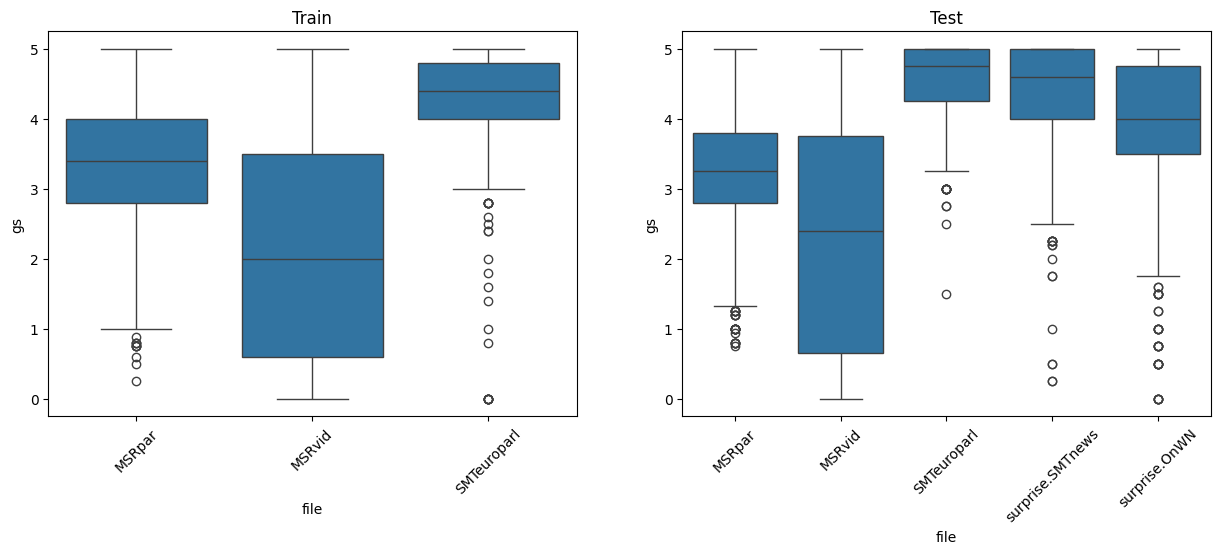

In [10]:
# Plot the distribution of the gold standard in the train and test sets for each of the files
import matplotlib.pyplot as plt
import seaborn as sns

# create subplots of boxplots for train and test
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# plot boxplots for train
sns.boxplot(x="file", y="gs", data=df_train, ax=axes[0])
# plot boxplots for test
sns.boxplot(x="file", y="gs", data=df_test, ax=axes[1])
# set title
axes[0].set_title("Train")
axes[1].set_title("Test")

# Rotate x-axis labels
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
# display plot
plt.show()


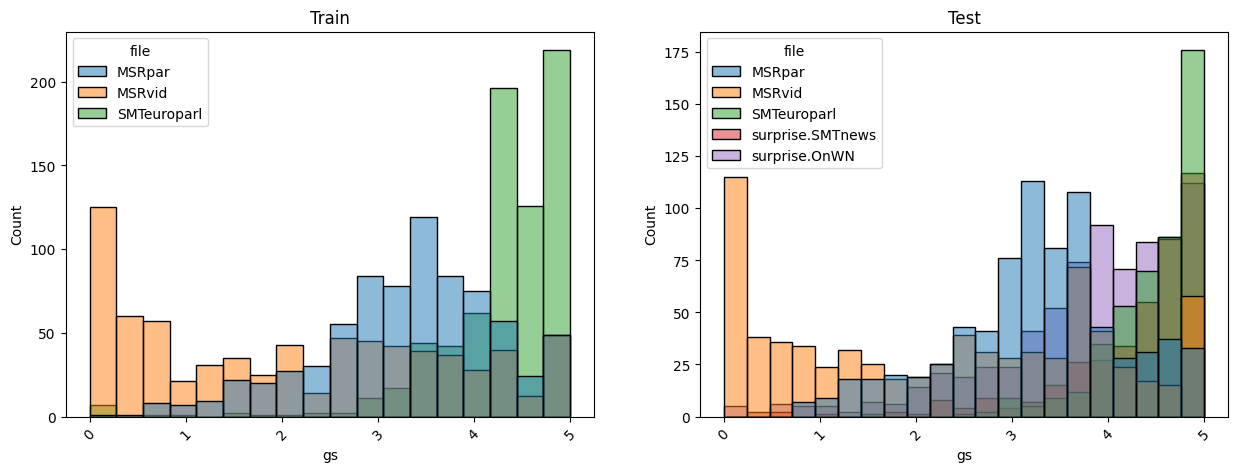

In [11]:
# Plot the histogram of the gold standard in the train and test sets for each of the files
import matplotlib.pyplot as plt
import seaborn as sns

# create subplots of boxplots for train and test hue file
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
# plot boxplots for train
sns.histplot(x="gs", data=df_train, hue="file", ax=axes[0])
# plot boxplots for test
sns.histplot(x="gs", data=df_test, hue="file", ax=axes[1])
# set title
axes[0].set_title("Train")
axes[1].set_title("Test")

# Rotate x-axis labels
for ax in axes:
    plt.sca(ax)
    plt.xticks(rotation=45)
# display plot
plt.show()

# Build Features

The following features will be used to train the model:

**Text Comparison**
- String similarity features: 
   - **Longest Common Substring (`lcstr`):**
      - This measure calculates the length of the longest common substring shared between two strings. A substring is a contiguous sequence of characters that appears in both strings.
   - **Longest Common Subsequence (`lcseq`):**
      - This measure computes the length of the longest common subsequence between two strings. A subsequence is not necessarily contiguous, but it preserves the order of characters.
   - **Greedy String Tiling (`gst`):**
      - Greedy String Tiling measures similarity based on the length of the longest common substrings, allowing for overlaps. It identifies common substrings between two strings in a way that maximizes coverage.
   - **Jaro Similarity (`jaro`):**
      - Jaro similarity is a measure of similarity between two strings. It considers the number of matching characters and the transpositions (swaps) of characters. The result is normalized to a value between 0 and 1.
   - **Jaro-Winkler Similarity (`jaro_w`):**
      - Jaro-Winkler is an extension of Jaro similarity that gives extra weight to common prefixes. It is particularly useful when comparing strings that are expected to share a common prefix.
   - **Monge-Elkan Similarity (`monge`):**
      - Monge-Elkan similarity is based on the similarity of token sets. It calculates a similarity score by comparing the tokens of the two strings. This can be useful when comparing strings with different tokenizations.
   - **Levenshtein Distance (`levenshtein`):**
      - Levenshtein distance measures the minimum number of single-character edits (insertions, deletions, or substitutions) required to transform one string into another. The distance is inversely related to similarity.

- N-Gram similarity features: For N-grams from 1 to 5 (choice based on \[1\]). 3 different tokenizations are used: nltk WordNet tokenizer, Spacy lemmas and Spacy+Porter-Stemmer (best performing one during the labs.) the following features will be used:
   - **Jaccard similarity (`jaccard`):**
      - Jaccard similarity is a measure of similarity between two sets. It is defined as the size of the intersection divided by the size of the union of the two sets.
   - **Dice similarity (`dice`):**
      - Dice similarity is a measure of similarity between two sets. It is defined as twice the size of the intersection divided by the sum of the sizes of the two sets.
    - **Overlap coefficient (`overlap`):**
      - Overlap coefficient is a measure of similarity between two sets. It is defined as the size of the intersection divided by the size of the smaller set.
    - **Cosine similarity (`cosine`):**
      - Cosine similarity is a measure of similarity between two vectors. It is defined as the dot product of the two vectors divided by the product of their magnitudes.

**Semantic Comparison**
- Semantic similarity features: For each word in each sentence, its list of synsets is calculated. After that, the similarity measure for each word in sentence 1 with respect to sentence 2 is calculated using *the maximum of the similarities of its synsets with respect to those corresponding to sentence 2**. Given that similarity measures can be asymetric as in the case of Wu-Palmer, it is calculated in both directions and then averaged.
  - **Path similarity (`path`):**
    - Path similarity is a measure of similarity between two synsets. It is defined as the length of the shortest path between the two synsets in the hypernym hierarchy.
  - **Wu-Palmer Similarity (`wup`):**
    - Wu-Palmer similarity is a measure of similarity between two synsets. It is defined as the depth of the two synsets in the hypernym hierarchy divided by the depth of their least common subsumer.
  - **Leacock-Chodorow Similarity (`lch`):**
    - Leacock-Chodorow similarity is a measure of similarity between two synsets. It is defined as -log(p/2d) where p is the shortest path length between the two synsets and d is the maximum depth of the taxonomy.
   - **Lin Similarity (`lin`):**
     - Lin similarity is a measure of similarity between two synsets. It is defined as 2log(p/(p1+p2)) where p is the shortest path length between the two synsets, p1 is the shortest path length from the first synset to the root, and p2 is the shortest path length from the second synset to the root.

- Word Disambiguation Similarity Measures: Instead of using all the synsets, the result of word disambiguation using the context of the synsets using Lesk algorithm. After that, the same word similarity and word semantic similarity than before are calculated. (Variable names: )


**Structure Comparison**
- Stopwords similarity features: n-gram similarity features are calculated using only stopwords.


In [12]:
############### AUXILIARY FUNCTIONS #####################

def dice_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)
    try:
        return 2*len(x_n_y) / (len(x) + len(y))
    except ZeroDivisionError:
        return 0

def overlap_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)
    try:
        return len(x_n_y) / min(len(x), len(y))
    except ZeroDivisionError:
        return 0

def cosine_sim(x, y):
    x = set(x)
    y = set(y)
    x_n_y = x.intersection(y)

    if len(x_n_y) == 0:
        return 0
    
    try:
        return len(x_n_y) / np.sqrt(len(x)*len(y))
    except ZeroDivisionError:
        return 0

def jaccard_sim(x, y):
    '''
    Get the Jaccard similarity between two sets
    '''
    x = set(x)
    y = set(y)
    try:
        return 1 - jaccard_distance(x, y)
    except ZeroDivisionError:
        return 0


def get_similarities(X, d_sim=None):
    '''
    Get the similarities between two sentences
    '''
    df_sim = pd.DataFrame()
    if d_sim is None:
        d_sim = {"jaccard": jaccard_sim, "dice": dice_sim, 
                  "overlap": overlap_sim, "cosine": cosine_sim}
        
    for name, sim in d_sim.items():
        df_sim[name] = X.apply(lambda x: sim(x["sent1"], x["sent2"]), axis=1)
        
    return df_sim


def get_path_similarity(syn1, syn2):
    return syn1.path_similarity(syn2)

def get_lch_similarity(syn1, syn2):
    try:
        return syn1.lch_similarity(syn2)
    except:
        return None
    
def get_wup_similarity(syn1, syn2):
    try:
        return syn1.wup_similarity(syn2)
    except:
        return None
    
def get_lin_similarity(syn1, syn2):
    try:
        return syn1.lin_similarity(syn2, brown_ic)
    except:
        return None
    
def longest_common_substring(str1, str2):
    return textdistance.lcsstr.similarity(str1, str2)

def longest_common_subsequence(str1, str2):
    return textdistance.lcsseq.similarity(str1, str2)

def greedy_string_tiling(str1, str2):
    return textdistance.ratcliff_obershelp.similarity(str1, str2)

def jaro_similarity(str1, str2):
    return textdistance.jaro.similarity(str1, str2)  # Use jellyfish for Jaro similarity

def jaro_winkler_similarity(str1, str2):
    return textdistance.jaro_winkler.similarity(str1, str2)

def monge_elkan_similarity(str1, str2):
    return textdistance.monge_elkan.similarity(str1, str2)

def levenshtein_distance(str1, str2):
    return textdistance.levenshtein.similarity(str1, str2)


def get_textdistance_similarities(X, d_sim=None):
    '''
    Get the similarities between two sentences
    '''
    if d_sim is None:
        d_sim = {"lcstr": longest_common_substring, "lcseq": longest_common_subsequence, 
                  "gst": greedy_string_tiling, "jaro": jaro_similarity, 
                  "jaro_w": jaro_winkler_similarity, "monge": monge_elkan_similarity, 
                  "levenshtein": levenshtein_distance}

    df_sim = pd.DataFrame()
    for name, sim in d_sim.items():
        df_sim[name] = X.apply(lambda x: sim(x["sent1"], x["sent2"]), axis=1)

    return df_sim

def get_word_ngrams(text, n, tokenize=True):
    if tokenize:
        words = nltk.word_tokenize(text)
    else:
        words = text
    return list(ngrams(words, n))

def get_ngrams_similarity(x, y, sim, n=2, tokenize=True):
    ngrams1 = get_word_ngrams(x, n, tokenize=tokenize)
    ngrams2 = get_word_ngrams(y, n, tokenize=tokenize)
    return sim(ngrams1, ngrams2)

def get_ngrams_similarities(X, d_sim=None, nmax=5, tokenize=True):
    '''
    Get the similarities between two sentences
    '''
    if d_sim is None:
        d_sim = {"jaccard": jaccard_sim, "dice": dice_sim, 
                  "overlap": overlap_sim, "cosine": cosine_sim}

    df_sim = pd.DataFrame()
    for n in range(1, nmax+1):
        for name, sim in d_sim.items():
            df_sim[name + f"_n_{n}"] = X.apply(lambda x: get_ngrams_similarity(x["sent1"], x["sent2"], sim, n=n, tokenize=tokenize), axis=1)
        
    return df_sim

def calculate_idf(term, documents):
    document_frequency = sum(1 for document in documents if term in document)
    if document_frequency == 0:
        return 0.0
    else:
        return np.log(len(documents) / document_frequency)
    
def compare_synsets(ls_ls_syns1, ls_ls_syns2, documents=None, similarity=get_wup_similarity, idf=True):

    d_out = {}
    for w, ls_syns1 in ls_ls_syns1:
        d_out[w] = []
        for _, ls_syns2 in ls_ls_syns2:
            for syn1 in ls_syns1:
                for syn2 in ls_syns2:
                    out = similarity(syn1, syn2) if syn1.pos() == syn2.pos() else 0
                    out = 0 if out is None else out
                    d_out[w].append(out)
                    # print(syn1, syn2, out)
        
        if d_out[w] != []:
            if idf:
                d_out[w] = calculate_idf(w, documents) * np.max(d_out[w])
            else:
                d_out[w] = np.max(d_out[w])
        else:
            d_out[w] = 0

    return d_out

def get_sem_similarities(X, d_sim=None, idf=True, documents=None):
    '''
    Get the similarities between two sentences
    '''
    if d_sim is None:
        d_sim = {"wup": get_wup_similarity, "path": get_path_similarity, 
                  "lch": get_lch_similarity, "lin": get_lin_similarity}

    df_sim = pd.DataFrame()
    for name, sim in d_sim.items():
        if idf:
            sim_fw = X.apply(lambda x: sum(compare_synsets(x.iloc[0], x.iloc[1], documents, similarity=sim).values()), axis=1)
            sim_bw = X.apply(lambda x: sum(compare_synsets(x.iloc[1], x.iloc[0], documents, similarity=sim).values()), axis=1)
        else:
            sim_fw = X.apply(lambda x: sum(compare_synsets(x.iloc[0], x.iloc[1], idf=idf, similarity=sim).values()), axis=1)
            sim_bw = X.apply(lambda x: sum(compare_synsets(x.iloc[1], x.iloc[0], idf=idf, similarity=sim).values()), axis=1)
        
        df_sim[name] = (sim_fw + sim_bw) / 2

    return df_sim


def get_sem_similarities_synsets_sets(X, d_sim=None, idf=True, documents=None):
    '''
    Get the similarities between two sets of synsets
    '''
    if d_sim is None:
        d_sim = {"wup": get_wup_similarity, "path": get_path_similarity, 
                  "lch": get_lch_similarity, "lin": get_lin_similarity}

    df_sim = pd.DataFrame()
    for name, sim in d_sim.items():
        if idf:
            sim_fw = X.apply(lambda x: sum(compare_synsets_wd(x.iloc[0], x.iloc[1], documents, similarity=sim).values()), axis=1)
            sim_bw = X.apply(lambda x: sum(compare_synsets_wd(x.iloc[1], x.iloc[0], documents, similarity=sim).values()), axis=1)
        else:
            sim_fw = X.apply(lambda x: sum(compare_synsets_wd(x.iloc[0], x.iloc[1], idf=idf, similarity=sim).values()), axis=1)
            sim_bw = X.apply(lambda x: sum(compare_synsets_wd(x.iloc[1], x.iloc[0], idf=idf, similarity=sim).values()), axis=1)
        
        df_sim[name] = (sim_fw + sim_bw) / 2

    return df_sim

def compare_synsets_wd(ls_ls_syns1, ls_ls_syns2, documents=None, similarity=get_wup_similarity):
    #print('ls_ls_syns1', ls_ls_syns1)
    d_out = {}
    for s1 in ls_ls_syns1:
        d_out[s1] = []
        for s2 in ls_ls_syns2:
            try:
                out = similarity(s1, s2)
            except Exception as e:
                out = 0
            out = 0 if out is None else out
            d_out[s1].append(out)
            # print(syn1, syn2, out)
        
        if d_out[s1] != []:
            d_out[s1] = np.max(d_out[s1])
        else:
            d_out[s1] = 0

    return d_out

def apply_lesk_algorithm(nlp_sentence):
    '''
    Apply the Lesk algorithm to a sentence
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    spacy_to_wordnet_pos = {
        "ADJ": "a",    # Adjective
        "NOUN": "n",   # Noun
        "PROPN": "n",  # Proper noun
        "VERB": "v",   # Verb
        "ADV": "r",    # Adverb
        "NUM": "n",    # Numeral
        "PRON": "n",   # Pronoun
        "ADP": "n",    # Adposition (preposition or postposition)
    }

    
    # Get the POS tag
    ls_postagged_lemmas = [(w.lemma_.lower(), w.pos_) for w in nlp_sentence 
                            if not w.is_stop and not w.is_punct]

    # Convert the POS tag to the WordNet POS tag
    ls_postagged_lemmas = [(lemma, spacy_to_wordnet_pos.get(pos)) 
                         for lemma, pos in ls_postagged_lemmas]
    
    # Instead of using the original text for disambiguation, we use only the lemmas
    text = ' '.join([lemma for lemma, _ in ls_postagged_lemmas])

    disamb_set = set()
    for lemma, pos in ls_postagged_lemmas:
        # If it has a disambiguation synset, get it
        get_disamb = nltk.wsd.lesk(text, lemma, pos)

        # Otherwise, get the first synset
        if get_disamb is None:
            try:
                get_disamb = wn.synsets(lemma, pos)[0].name()
            except IndexError:
                get_disamb = lemma
        # If there isn't a first sentence, get the lemma
        else:
            get_disamb = get_disamb.name()

        disamb_set.add(get_disamb)
        
    return disamb_set

def apply_lesk_algorithm_and_return_synset(nlp_sentence):
    '''
    Apply the Lesk algorithm to a sentence
    Input: text - string
    Output: ls_processed_text - list of words
    '''

    spacy_to_wordnet_pos = {
        "ADJ": "a",    # Adjective
        "NOUN": "n",   # Noun
        "PROPN": "n",  # Proper noun
        "VERB": "v",   # Verb
        "ADV": "r",    # Adverb
        "NUM": "n",    # Numeral
        "PRON": "n",   # Pronoun
        "ADP": "n",    # Adposition (preposition or postposition)
    }

    
    # Get the POS tag
    ls_postagged_lemmas = [(w.lemma_.lower(), w.pos_) for w in nlp_sentence 
                            if not w.is_stop and not w.is_punct]

    # Convert the POS tag to the WordNet POS tag
    ls_postagged_lemmas = [(lemma, spacy_to_wordnet_pos.get(pos)) 
                         for lemma, pos in ls_postagged_lemmas]
    
    # Instead of using the original text for disambiguation, we use only the lemmas
    text = ' '.join([lemma for lemma, _ in ls_postagged_lemmas])

    disamb_set = set()
    for lemma, pos in ls_postagged_lemmas:
        # If it has a disambiguation synset, get it
        get_disamb = nltk.wsd.lesk(text, lemma, pos)

        # Otherwise, get the first synset
        if get_disamb is None:
            try:
                get_disamb = wn.synsets(lemma, pos)[0]
            except IndexError:
                get_disamb = lemma
        # If there isn't a first sentence, get the lemma
        else:
            get_disamb = get_disamb

        disamb_set.add(get_disamb)
        
    return disamb_set

In [13]:

class FeatureExtractor:
    def __init__(self, prep_func=prep_func, clean_func=clean_func):
        self.prep_func = prep_func
        self.clean_func = clean_func
                 
    def fit_transform(self, df, documents=None):

        prep_func = self.prep_func
        clean_func = self.clean_func

        print("Building auxiliary dataframes...")
        ## BUILD NECESSARY DATAFRAMES
        # Preprocess using spacy and clean and return lists
        print("- Tokenized (list)")
        df_prep_ls = df[["sent1", "sent2"]].copy()
        df_prep_ls["sent1"] = df_prep_ls["sent1"].apply(lambda x: prep_func(x, out_set=False))
        df_prep_ls["sent2"] = df_prep_ls["sent2"].apply(lambda x: prep_func(x, out_set=False))
        
        print("- Tokenized (set)")
        # Preprocess using spacy and clean and return sets
        df_prep = df_prep_ls.copy()
        df_prep["sent1"] = df_prep["sent1"].apply(lambda x: set(x))
        df_prep["sent2"] = df_prep["sent2"].apply(lambda x: set(x))
        
        print("- Clean Strings")
        # Clean and return strings
        df_clean = df[["sent1", "sent2"]].copy()
        df_clean["sent1"] = df_clean["sent1"].apply(lambda x: clean_func(x))
        df_clean["sent2"] = df_clean["sent2"].apply(lambda x: clean_func(x))

        print("- Synsets")
        # Get synsets for each token
        df_synsets = df[['sent1', 'sent2']].copy()
        df_synsets = df_synsets.map(lambda x: [(token.text, token._.wordnet.synsets()) for token in nlp(x)
                                                if not token.is_stop and not token.is_punct 
                                                and not token.is_space])
        
        print("- Stopwords")
        df_stops = df_clean[["sent1", "sent2"]].copy()
        df_stops["sent1"] = df_stops["sent1"].apply(lambda x: [token.text for token in nlp(x) if token.is_stop and not token.is_punct])
        df_stops["sent2"] = df_stops["sent2"].apply(lambda x: [token.text for token in nlp(x) if token.is_stop and not token.is_punct])

        print("- Porter Stemmer")
        df_stem = df_prep[["sent1", "sent2"]].copy()
        df_stem = df_stem.map(lambda x: {PorterStemmer().stem(xx) for xx in x})

        print("- Word disambiguation")
        df_wd = df_clean[['sent1', 'sent2']].copy()
        df_wd["sent1"] = df_wd["sent1"].apply(lambda x: apply_lesk_algorithm(nlp(x)))
        df_wd["sent2"] = df_wd["sent2"].apply(lambda x: apply_lesk_algorithm(nlp(x)))

        print("- Word disambiguation Semantic")
        df_wd_s = df_clean[['sent1', 'sent2']].copy()
        df_wd_s["sent1"] = df_wd_s["sent1"].apply(lambda x: apply_lesk_algorithm_and_return_synset(nlp(x)))
        df_wd_s["sent2"] = df_wd_s["sent2"].apply(lambda x: apply_lesk_algorithm_and_return_synset(nlp(x)))


        print("\n")
        print("Building features...")
        ## BUILD FEATURES

        # df_features = pd.DataFrame(df["file"].values, columns=["file"])
        df_features = pd.DataFrame()

        print("- String Similarities")
        # Get String Similarities (df_clean strings)
        df_textdistance = get_textdistance_similarities(df_clean)
        if len(df_features.columns.intersection(df_textdistance.columns)) == 0:
            df_features = pd.concat([df_features, df_textdistance], axis=1)

        print("- N-Grams Similarities")
        # Get N-Grams Similarities (df_clean strings)
        
        print("---- Use wordnet as a tokenizer")
        # ---- Use wordnet as a tokenizer
        df_ngram_sim = get_ngrams_similarities(df_clean)

        if len(df_features.columns.intersection(df_ngram_sim.columns)) == 0:
            df_features = pd.concat([df_features, df_ngram_sim], axis=1)
        
        print("---- Use spacy preprocessed as a tokenizer")
        # ---- Use spacy preprocessed data as tokens
        df_ngram_sim_spacy = get_ngrams_similarities(df_prep_ls, tokenize=False)
        df_ngram_sim_spacy.columns = [col + "_spacy" for col in df_ngram_sim_spacy.columns]

        if len(df_features.columns.intersection(df_ngram_sim_spacy.columns)) == 0:
            df_features = pd.concat([df_features, df_ngram_sim_spacy], axis=1)

        print("---- Porter Stemmer")
        # Get ngram distances for Porter Stemmer
        df_ngram_stem = get_ngrams_similarities(df_stem, tokenize=False)
        df_ngram_stem.columns = [col + "_stem" for col in df_ngram_stem.columns]

        if len(df_features.columns.intersection(df_ngram_stem.columns)) == 0:
            df_features = pd.concat([df_features, df_ngram_stem], axis=1)

        # Get Wordnet Similarities (df_synsets)
        
        print("- Wordnet Semantic Similarities")
        # These are the documents to calculate the idf. In case of train, we don't have
        # to provide it, since it will be calculated from the train data. In case of test,
        # we have to provide it, since we don't have the train data.
        
        if documents is None:
            print("---- IDF Calculation")
            documents = df_prep["sent1"].tolist() + df_prep["sent2"].tolist()

        # print("---- IDF Weighted")
        # # Calculate similarities, weight them with idf and average forward and backwards
        # # this is mainly for asymetric similarities like Wu Palmer
        # df_sem_sim = get_sem_similarities(df_synsets, idf=True, documents=documents)
        # df_sem_sim.columns = [col + "_idf" for col in df_sem_sim.columns]
    
        # if len(df_sem_sim.columns.intersection(df_features.columns)) == 0:
        #     df_features = pd.concat([df_features, df_sem_sim], axis=1)

        print("---- NON IDF Weighted")
        # Do the same without idf
        df_sem_sim_not_idf = get_sem_similarities(df_synsets, idf=False)
        if len(df_features.columns.intersection(df_sem_sim_not_idf.columns)) == 0:
            df_features = pd.concat([df_features, df_sem_sim_not_idf], axis=1)

        print("---- Word Disambiguation ")
        df_wd_sim = get_similarities(df_wd)
        df_wd_sim.columns = [col + "_wd" for col in df_wd_sim.columns]

        if len(df_features.columns.intersection(df_wd_sim.columns)) == 0:
            df_features = pd.concat([df_features, df_wd_sim], axis=1)

        print("---- Word Disambiguation Semantic")
        df_wd_s_sim = get_sem_similarities_synsets_sets(df_wd_s)
        df_wd_s_sim.columns = [col + "_wd_s" for col in df_wd_s_sim.columns]

        if len(df_features.columns.intersection(df_wd_s_sim.columns)) == 0:
            df_features = pd.concat([df_features, df_wd_s_sim], axis=1)
            
        print("---- Similarity Stopwords")
        df_ngram_stop = get_ngrams_similarities(df_stops, tokenize=False)
        df_ngram_stop.columns = [col + "_stop" for col in df_ngram_stop.columns]
        
        if len(df_features.columns.intersection(df_ngram_stop.columns)) == 0:
            df_features = pd.concat([df_features, df_ngram_stop], axis=1)

        # self.documents = documents
        return df_features
    
    def transform(self, df):
        #return self.fit(df, documents=self.documents)
        return self.fit_transform(df)
        
    

In [14]:
prep_func = partial(spacy_preprocess_reviews, clean_func=clean_func, out_set=False)

df_train_sample = df_train.sample(30, random_state=42)
df_test_sample = df_test.sample(20, random_state=42)

fe = FeatureExtractor()
X_train_sample = fe.fit_transform(df_train_sample)
X_test_sample = fe.transform(df_test_sample)

Building auxiliary dataframes...
- Tokenized (list)
- Tokenized (set)
- Clean Strings
- Synsets
- Stopwords
- Porter Stemmer
- Word disambiguation
- Word disambiguation Semantic


Building features...
- String Similarities
- N-Grams Similarities
---- Use wordnet as a tokenizer
---- Use spacy preprocessed as a tokenizer
---- Porter Stemmer
- Wordnet Semantic Similarities
---- IDF Calculation
---- NON IDF Weighted
---- Word Disambiguation 
---- Word Disambiguation Semantic
---- Similarity Stopwords
Building auxiliary dataframes...
- Tokenized (list)
- Tokenized (set)
- Clean Strings
- Synsets
- Stopwords
- Porter Stemmer
- Word disambiguation
- Word disambiguation Semantic


Building features...
- String Similarities
- N-Grams Similarities
---- Use wordnet as a tokenizer
---- Use spacy preprocessed as a tokenizer
---- Porter Stemmer
- Wordnet Semantic Similarities
---- IDF Calculation
---- NON IDF Weighted
---- Word Disambiguation 
---- Word Disambiguation Semantic
---- Similarity Stopwo

In [15]:
X_train_sample
print(X_train_sample.shape)

(30, 99)


In [16]:
for col in X_train_sample.columns:
    print("-", col)

- lcstr
- lcseq
- gst
- jaro
- jaro_w
- monge
- levenshtein
- jaccard_n_1
- dice_n_1
- overlap_n_1
- cosine_n_1
- jaccard_n_2
- dice_n_2
- overlap_n_2
- cosine_n_2
- jaccard_n_3
- dice_n_3
- overlap_n_3
- cosine_n_3
- jaccard_n_4
- dice_n_4
- overlap_n_4
- cosine_n_4
- jaccard_n_5
- dice_n_5
- overlap_n_5
- cosine_n_5
- jaccard_n_1_spacy
- dice_n_1_spacy
- overlap_n_1_spacy
- cosine_n_1_spacy
- jaccard_n_2_spacy
- dice_n_2_spacy
- overlap_n_2_spacy
- cosine_n_2_spacy
- jaccard_n_3_spacy
- dice_n_3_spacy
- overlap_n_3_spacy
- cosine_n_3_spacy
- jaccard_n_4_spacy
- dice_n_4_spacy
- overlap_n_4_spacy
- cosine_n_4_spacy
- jaccard_n_5_spacy
- dice_n_5_spacy
- overlap_n_5_spacy
- cosine_n_5_spacy
- jaccard_n_1_stem
- dice_n_1_stem
- overlap_n_1_stem
- cosine_n_1_stem
- jaccard_n_2_stem
- dice_n_2_stem
- overlap_n_2_stem
- cosine_n_2_stem
- jaccard_n_3_stem
- dice_n_3_stem
- overlap_n_3_stem
- cosine_n_3_stem
- jaccard_n_4_stem
- dice_n_4_stem
- overlap_n_4_stem
- cosine_n_4_stem
- jaccard_n_

As a result of the feature extraction, we have a total of 99 features. Some dimensionality reduction techniques will be applied to reduce the number of features. Given that running all the features, due to the combinatorial nature of synsets distances computation, takes a lot of time, we will load data from a previous run.

In [17]:
df_train = pd.read_csv('new_features/all_features_train.csv')
df_test = pd.read_csv('new_features/all_features_test.csv')

df_train.head()

lcstr  lcseq       gst      jaro    jaro_w     monge  levenshtein  \
0     75    105  0.738007  0.865225  0.919135  0.006369          104   
1     24     53  0.670886  0.738972  0.843383  0.015873           50   
2     27     56  0.464865  0.782203  0.782203  0.010989           39   
3    129    133  0.833856  0.901976  0.941186  0.007407          133   
4     20     54  0.507614  0.696501  0.696501  0.009342           44   

   jaccard_n_1  dice_n_1  overlap_n_1  cosine_n_1  jaccard_n_2  dice_n_2  \
0     0.548387  0.708333     0.772727    0.710806     0.378378  0.549020   
1     0.444444  0.615385     0.727273    0.622799     0.136364  0.240000   
2     0.363636  0.533333     0.533333    0.533333     0.214286  0.352941   
3     0.655172  0.791667     0.950000    0.802897     0.600000  0.750000   
4     0.250000  0.400000     0.437500    0.401478     0.030303  0.058824   

   overlap_n_2  cosine_n_2  jaccard_n_3  dice_n_3  overlap_n_3  cosine_n_3  \
0     0.608696    0.551677     0.324324  0.489796     0.545455    0.492366   
1     0.300000    0.244949     0.045455  0.086957     0.111111    0.089087   
2     0.375000    0.353553     0.103448  0.187500     0.200000    0.187867   
3     0.900000    0.760639     0.586207  0.739130     0.894737    0.750568   
4     0.062500    0.058926     0.000000  0.000000     0.000000    0.000000   

   jaccard_n_4  dice_n_4  overlap_n_4  cosine_n_4  jaccard_n_5  dice_n_5  \
0     0.305556  0.468085     0.523810    0.470757     0.285714  0.444444   
1     0.000000  0.000000     0.000000    0.000000     0.000000  0.000000   
2     0.071429  0.133333     0.142857    0.133631     0.037037  0.071429   
3     0.571429  0.727273     0.888889    0.739600     0.555556  0.714286   
4     0.000000  0.000000     0.000000    0.000000     0.000000  0.000000   

   overlap_n_5  cosine_n_5  jaccard_n_1_spacy  dice_n_1_spacy  \
0     0.500000    0.447214           0.562500        0.720000   
1     0.000000    0.000000           0.444444        0.615385   
2     0.076923    0.071611           0.384615        0.555556   
3     0.882353    0.727607           0.647059        0.785714   
4     0.000000    0.000000           0.142857        0.250000   

   overlap_n_1_spacy  cosine_n_1_spacy  jaccard_n_2_spacy  dice_n_2_spacy  \
0           0.900000          0.734847           0.533333        0.695652   
1           0.800000          0.632456           0.222222        0.363636   
2           0.625000          0.559017           0.066667        0.125000   
3           0.916667          0.793857           0.625000        0.769231   
4           0.272727          0.250873           0.047619        0.090909   

   overlap_n_2_spacy  cosine_n_2_spacy  jaccard_n_3_spacy  dice_n_3_spacy  \
0           0.888889          0.712697              0.500        0.666667   
1           0.500000          0.377964              0.125        0.222222   
2           0.142857          0.125988              0.000        0.000000   
3           0.909091          0.778499              0.600        0.750000   
4           0.100000          0.091287              0.000        0.000000   

   overlap_n_3_spacy  cosine_n_3_spacy  jaccard_n_4_spacy  dice_n_4_spacy  \
0           0.875000          0.686406           0.461538        0.631579   
1           0.333333          0.235702           0.000000        0.000000   
2           0.000000          0.000000           0.000000        0.000000   
3           0.900000          0.760639           0.571429        0.727273   
4           0.000000          0.000000           0.000000        0.000000   

   overlap_n_4_spacy  cosine_n_4_spacy  jaccard_n_5_spacy  dice_n_5_spacy  \
0           0.857143          0.654654           0.416667        0.588235   
1           0.000000          0.000000           0.000000        0.000000   
2           0.000000          0.000000           0.000000        0.000000   
3           0.888889          0.739600           0.538462        0.700000   
4           0.000000  

In [29]:
df_train[df_train.file == "SMTeuroparl"]

lcstr  lcseq       gst      jaro    jaro_w     monge  levenshtein  \
1500     28    127  0.654155  0.779187  0.867512  0.005235           96   
1501     21     77  0.611111  0.764647  0.858788  0.009258           67   
1502     47    110  0.822642  0.789079  0.873447  0.006935          107   
1503     29     95  0.818966  0.857150  0.914290  0.008621           78   
1504     36    158  0.627767  0.776032  0.820825  0.003597          130   
...     ...    ...       ...       ...       ...       ...          ...   
2229     25     57  0.708075  0.724605  0.724605  0.011073           51   
2230     14     56  0.564103  0.690038  0.690038  0.008900           46   
2231     40     40  1.000000  1.000000  1.000000  2.000000           40   
2232     48    129  0.709859  0.770009  0.770009  0.005952          107   
2233      5     12  0.478261  0.678571  0.678571  0.052469           11   

      jaccard_n_1  dice_n_1  overlap_n_1  cosine_n_1  jaccard_n_2  dice_n_2  \
1500     0.526316  0.689655     0.714286    0.690066     0.192308  0.322581   
1501     0.500000  0.666667     0.695652    0.667246     0.162791  0.280000   
1502     0.592593  0.744186     0.800000    0.746004     0.270270  0.425532   
1503     0.700000  0.823529     0.823529    0.823529     0.285714  0.444444   
1504     0.413043  0.584615     0.655172    0.588035     0.154930  0.268293   
...           ...       ...          ...         ...          ...       ...   
2229     0.478261  0.647059     0.647059    0.647059     0.307692  0.470588   
2230     0.413793  0.585366     0.600000    0.585540     0.176471  0.300000   
2231     1.000000  1.000000     1.000000    1.000000     1.000000  1.000000   
2232     0.566667  0.723404     0.739130    0.723568     0.309524  0.472727   
2233     0.444444  0.615385     0.666667    0.617213     0.000000  0.000000   

      overlap_n_2  cosine_n_2  jaccard_n_3  dice_n_3  overlap_n_3  cosine_n_3  \
1500     0.333333    0.322749     0.090909  0.166667     0.172414    0.166759   
1501     0.318182    0.282038     0.090909  0.166667     0.190476    0.167984   
1502     0.500000    0.430331     0.153846  0.266667     0.315789    0.269953   
1503     0.444444    0.444444     0.093750  0.171429     0.176471    0.171499   
1504     0.305556    0.270310     0.066667  0.125000     0.142857    0.125988   
...           ...         ...          ...       ...          ...         ...   
2229     0.470588    0.470588     0.185185  0.312500     0.312500    0.312500   
2230     0.315789    0.300376     0.085714  0.157895     0.166667    0.158114   
2231     1.000000    1.000000     1.000000  1.000000     1.000000    1.000000   
2232     0.481481    0.472805     0.173913  0.296296     0.307692    0.296500   
2233     0.000000    0.000000     0.000000  0.000000     0.000000    0.000000   

      jaccard_n_4  dice_n_4  overlap_n_4  cosine_n_4  jaccard_n_5  dice_n_5  \
1500     0.035714  0.068966     0.071429    0.069007     0.000000  0.000000   
1501     0.045455  0.086957     0.100000    0.087706     0.023256  0.045455   
1502     0.102564  0.186047     0.222222    0.188562     0.078947  0.146341   
1503     0.064516  0.121212     0.125000    0.121268     0.033333  0.064516   
1504     0.040000  0.076923     0.088235    0.077563     0.013333  0.026316   
...           ...       ...          ...         ...          ...       ...   
2229     0.111111  0.200000     0.200000    0.200000     0.076923  0.142857   
2230     0.028571  0.055556     0.058824    0.055641     0.000000  0.000000   
2231     1.000000  1.000000     1.000000    1.000000     1.000000  1.000000   
2232     0.104167  0.188679     0.200000    0.188982     0.085106  0.156863   
2233     0.000000  0.000000     0.000000    0.000000     0.000000  0.000000   

      overlap_n_5  cosine_n_5  jaccard_n_1_spacy  dice_n_1_spacy  \
1500     0.000000    0.000000           0.600000        0.750000   
1501     0.052632    0.045883           0.545455        0.705882   
1502     0.176471    0.148522 

In [30]:
df_test.head()

lcstr  lcseq       gst      jaro    jaro_w     monge  levenshtein  \
0     16     66  0.694737  0.740286  0.740286  0.010406           49   
1      8     52  0.630303  0.683423  0.683423  0.009685           47   
2     23     59  0.564356  0.799708  0.879825  0.008242           52   
3     31     62  0.716763  0.699693  0.699693  0.009084           62   
4     15     30  0.414815  0.644985  0.644985  0.010113           20   

   jaccard_n_1  dice_n_1  overlap_n_1  cosine_n_1  jaccard_n_2  dice_n_2  \
0     0.291667  0.451613     0.500000    0.453743     0.142857  0.250000   
1     0.259259  0.411765     0.437500    0.412479     0.096774  0.176471   
2     0.538462  0.700000     0.823529    0.708010     0.200000  0.333333   
3     0.619048  0.764706     0.866667    0.770054     0.333333  0.500000   
4     0.260870  0.413793     0.461538    0.416025     0.037037  0.071429   

   overlap_n_2  cosine_n_2  jaccard_n_3  dice_n_3  overlap_n_3  cosine_n_3  \
0     0.285714    0.251976     0.000000  0.000000     0.000000    0.000000   
1     0.187500    0.176777     0.032258  0.062500     0.066667    0.062622   
2     0.368421    0.334855     0.176471  0.300000     0.333333    0.301511   
3     0.600000    0.507093     0.259259  0.411765     0.500000    0.418330   
4     0.083333    0.072169     0.000000  0.000000     0.000000    0.000000   

   jaccard_n_4  dice_n_4  overlap_n_4  cosine_n_4  jaccard_n_5  dice_n_5  \
0     0.000000  0.000000     0.000000    0.000000        0.000  0.000000   
1     0.000000  0.000000     0.000000    0.000000        0.000  0.000000   
2     0.151515  0.263158     0.294118    0.264628        0.125  0.222222   
3     0.230769  0.375000     0.461538    0.381771        0.200  0.333333   
4     0.000000  0.000000     0.000000    0.000000        0.000  0.000000   

   overlap_n_5  cosine_n_5  jaccard_n_1_spacy  dice_n_1_spacy  \
0     0.000000    0.000000           0.285714        0.444444   
1     0.000000    0.000000           0.111111        0.200000   
2     0.250000    0.223607           0.466667        0.636364   
3     0.416667    0.340207           0.272727        0.428571   
4     0.000000    0.000000           0.142857        0.250000   

   overlap_n_1_spacy  cosine_n_1_spacy  jaccard_n_2_spacy  dice_n_2_spacy  \
0           0.444444          0.444444           0.066667        0.125000   
1           0.200000          0.200000           0.000000        0.000000   
2           0.777778          0.647150           0.111111        0.200000   
3           0.600000          0.447214           0.200000        0.333333   
4           0.333333          0.258199           0.076923        0.142857   

   overlap_n_2_spacy  cosine_n_2_spacy  jaccard_n_3_spacy  dice_n_3_spacy  \
0              0.125          0.125000           0.000000        0.000000   
1              0.000          0.000000           0.000000        0.000000   
2              0.250          0.204124           0.058824        0.111111   
3              0.500          0.353553           0.111111        0.200000   
4              0.200          0.149071           0.000000        0.000000   

   overlap_n_3_spacy  cosine_n_3_spacy  jaccard_n_4_spacy  dice_n_4_spacy  \
0           0.000000          0.000000                0.0             0.0   
1           0.000000          0.000000                0.0             0.0   
2           0.142857          0.113961                0.0             0.0   
3           0.333333          0.218218                0.0             0.0   
4           0.000000          0.000000                0.0             0.0   

   overlap_n_4_spacy  cosine_n_4_spacy  jaccard_n_5_spacy  dice_n_5_spacy  \
0                0.0               0.0                0.0             0.0   
1                0.0               0.0                0.0             0.0   
2                0.0               0.0                0.0             0.0   
3                0.0               0.0                0.0             0.0   
4                0.0  

In [18]:
print("Train data shape: ", df_train.shape)
print("Test data shape: ", df_test.shape)

Train data shape:  (2234, 101)
Test data shape:  (3108, 101)


# Model Selection #1

In [19]:
def train_and_test(model, grid, X_train, y_train, scaler=StandardScaler()):
    pipe = Pipeline([('scaler', scaler), ('model', model)])
    pearsonr_scorer = make_scorer(lambda x, y: pearsonr(x, y).statistic, greater_is_better=True)

    grid = GridSearchCV(pipe, grid, cv=10, scoring=pearsonr_scorer, verbose=10, n_jobs=-1)
    grid.fit(X_train, y_train)

    print("Best cross-validation score: {:.2f}".format(grid.best_score_))
    print("Best parameters: {}".format(grid.best_params_))
    return grid


## Model For All Datasets

In [20]:
def plot_feature_importances(rf, df):
    importances = rf.feature_importances_
    indices = np.argsort(importances)[::-1]
    names = [df.columns[i] for i in indices]
    plt.figure(figsize=(20, 10))
    plt.title("Feature Importance")
    plt.bar(range(df.shape[1]), importances[indices])
    plt.xticks(range(df.shape[1]), names, rotation=90)
    plt.show()

As there are 2 surprise datasets which aren't included in the training set, we will train a model for all the datasets. This model will be used to predict the similarity of `SMTnews` and `OnWN` datasets.

### Model for all datasets: Features Correlation

As it can be inferred from the following plots, there are some features which are highly correlated with the target feature. This means that if, for example, we use the feature `dice_n_1_stem` as our prediction, the metric we would obtain in train is 0.69 (as it is the correlation between the feature and the target). This is not a good idea as we would be overfitting the model to the train data. In order to avoid this, we will use a feature selection technique to select the best features. 

However, it makes sense that the features which are highly correlated with the target are the ones which are more useful to predict the target. However, there a problem of multicollinearity, for example between different distance metrics applied to the same tokenization. Ideally, features should be highly correlated with the target but not between them.

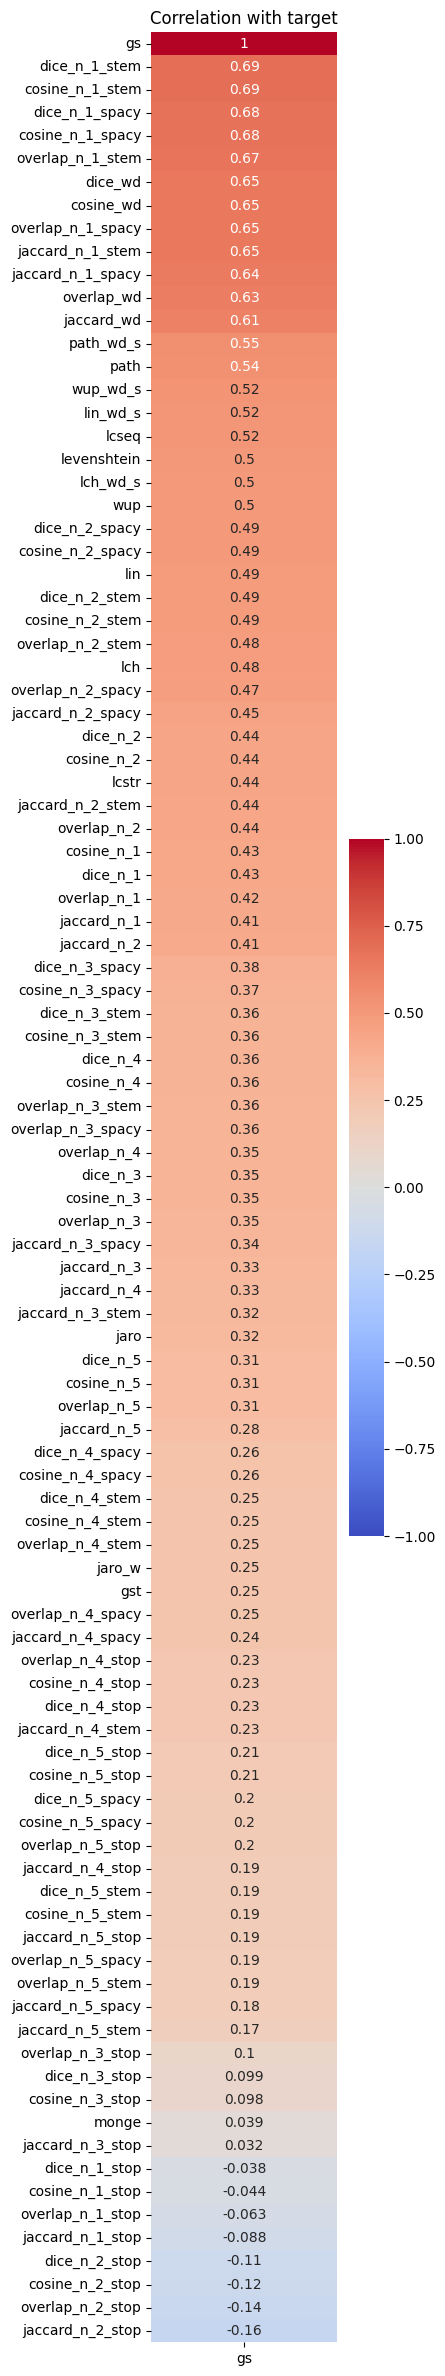

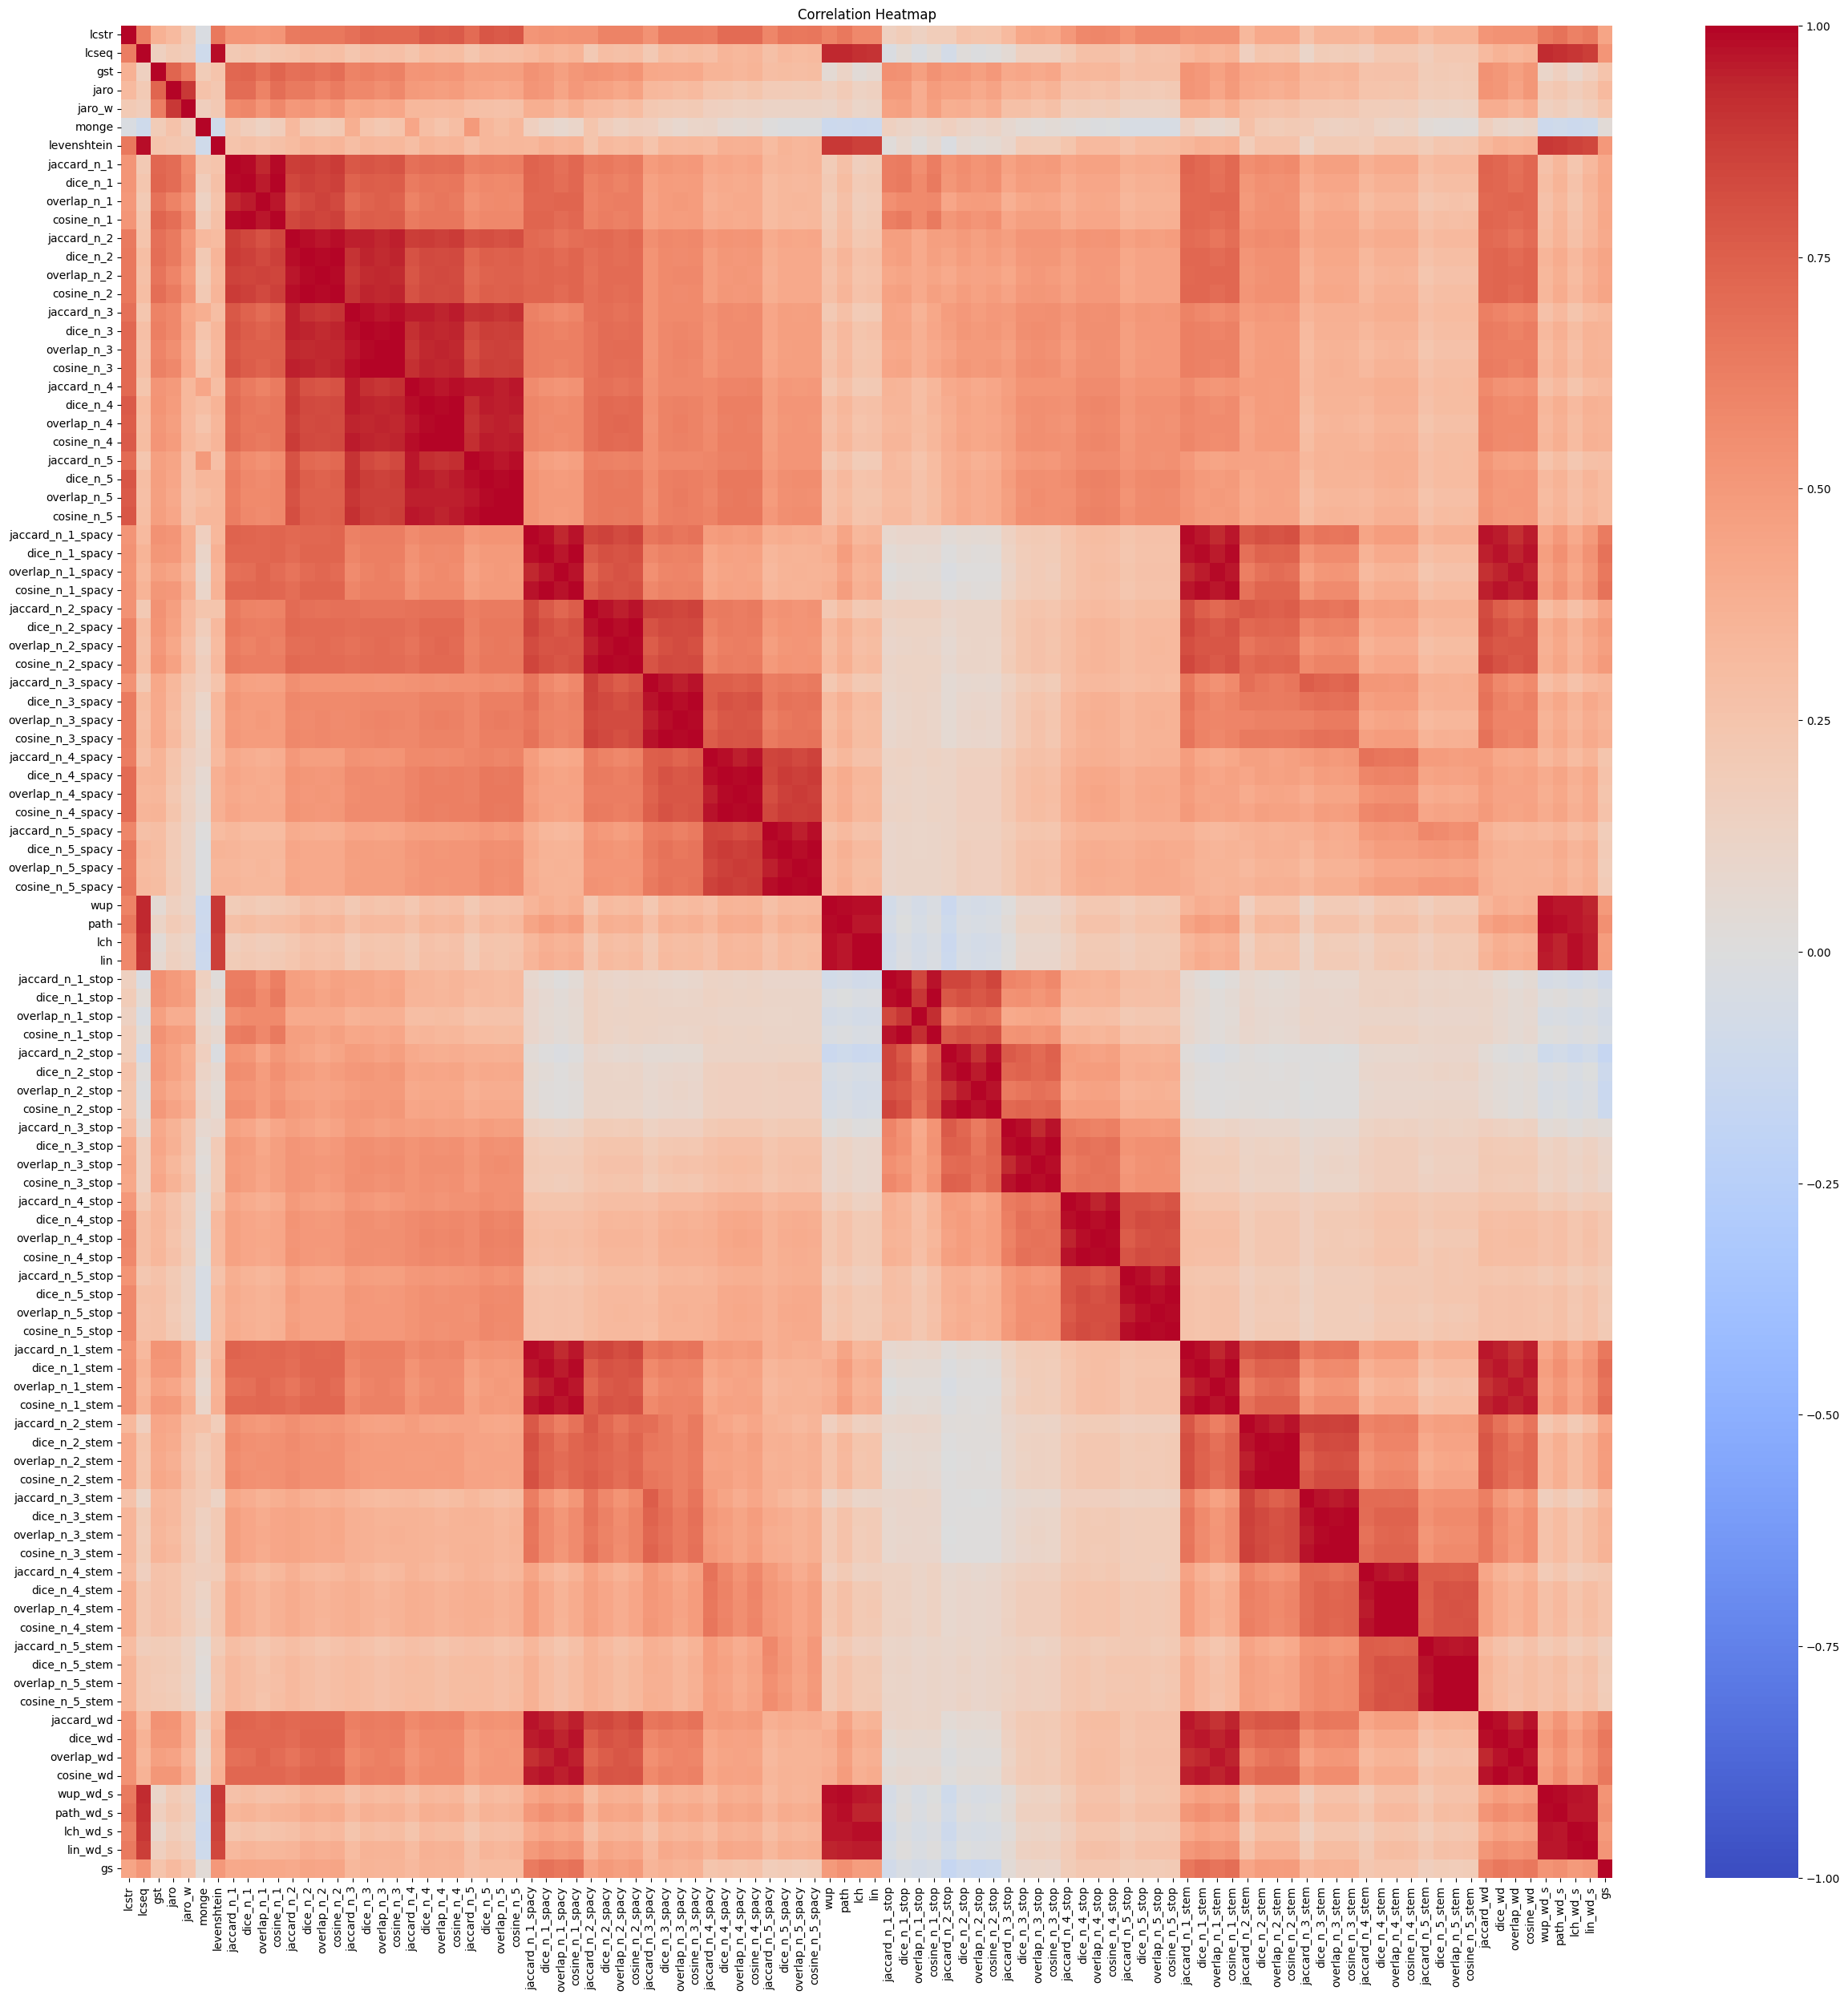

In [21]:
df_corr = df_train.drop(columns="file").copy()

# Scale the data so that the correlation is not affected by the scale
sc = StandardScaler()
df_corr = pd.DataFrame(sc.fit_transform(df_corr), columns=df_corr.columns)

# Plot corerelation with target
plt.figure(figsize=(3, 30))
sns.heatmap(df_corr.corr()[["gs"]].sort_values(by="gs", ascending=False), annot=True, cmap="coolwarm", label="big",
            vmin=-1, vmax=1)
plt.title("Correlation with target")
plt.show()

# Plot correlation heatmap to see collinearity
plt.figure(figsize=(30, 30))
sns.heatmap(df_corr.corr(), annot=False, cmap="coolwarm", label="big",
            vmin=-1, vmax=1)
plt.title("Correlation Heatmap")
plt.show()

## Training 1: All Features

For the first training, all the features will be used.

The selected algorithm is **Random Forest**. The reason for this choice is that it is a robust algorithm which is not prone to overfitting due to its bagging ensembling. In addition, it is a fast algorithm which can be trained in a reasonable time and it's not sensitive to the scale of the variables.

Another interesting property of Random Forest is that it can be used to calculate the importance of the features. This is useful to check if the feature selection technique is working properly.

The following hyperparameters have been explored during the grid search:
- **n_estimators**: The number of trees in the forest. A high number of trees will increase the training time but will reduce the variance of the model provided that the trees are not correlated.
- **max_depth**: The maximum depth of the tree. A high value will increase the variance of the model but producing a stronger learning.
- **min_samples_leaf**: The minimum number of samples required to be at a leaf node. This avoids the tree to learn the data by heart using very specific trees. A high value will reduce the variance of the model but it can produce underfitting.
- **max_features**: The number of features to consider when looking for the best split. There are 3 options: sqrt, log2 and None. The first two options will select the square root and the logarithm of the number of features respectively. The last option will use all the features. 

### All Datasets

In [35]:
# Random Forest
X_train = df_train.drop(columns=["gs", "file"])
y_train = df_train["gs"]

X_test = df_test.drop(columns=["gs", "file"])
y_test = df_test["gs"]

# Fix the random state
rf = RandomForestRegressor(random_state=42)
forest_param_grid = {'model__n_estimators': np.arange(100, 500, 50), 
                     'model__min_samples_leaf': [2, 4, 6, 8, 10],
                        'model__max_features': [None, 'sqrt', 'log2'],
                        # 'model__max_depth' : [None, 4, 6, 8, 10],
                    'model__n_jobs': [-1]}

rf_gscv = train_and_test(rf, forest_param_grid, X_train, y_train)

Fitting 10 folds for each of 120 candidates, totalling 1200 fits


[CV 3/10; 1/120] START model__max_features=None, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 10/10; 1/120] START model__max_features=None, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 9/10; 2/120] START model__max_features=None, model__min_samples_leaf=2, model__n_estimators=150, model__n_jobs=-1
[CV 3/10; 2/120] START model__max_features=None, model__min_samples_leaf=2, model__n_estimators=150, model__n_jobs=-1
[CV 2/10; 2/120] START model__max_features=None, model__min_samples_leaf=2, model__n_estimators=150, model__n_jobs=-1
[CV 6/10; 1/120] START model__max_features=None, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 6/10; 3/120] START model__max_features=None, model__min_samples_leaf=2, model__n_estimators=200, model__n_jobs=-1
[CV 8/10; 2/120] START model__max_features=None, model__min_samples_leaf=2, model__n_estimators=150, model__n_jobs=-1
[CV 7/10; 2/120] START model__max_features=None, model_

**Result**: The best model is obtained with the following hyperparameters:
- n_estimators: 250
- max_depth: Ignored because the depth will be determined by the min_samples_leaf parameter.
- min_samples_leaf: 2
- max_features: sqrt

In the following table we can see the results of the best performing combination of hyperparameters

In [36]:
pd.DataFrame(rf_gscv.cv_results_).sort_values(by="rank_test_score").head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
43       2.883649      0.583737         0.208189        0.168151   
42       2.288859      0.446441         0.250084        0.200203   
44       3.455774      0.644766         0.202666        0.137481   
45       3.552842      0.252345         0.124722        0.034064   
41       1.951790      0.416445         0.286024        0.225519   

   param_model__max_features param_model__min_samples_leaf  \
43                      sqrt                             2   
42                      sqrt                             2   
44                      sqrt                             2   
45                      sqrt                             2   
41                      sqrt                             2   

   param_model__n_estimators param_model__n_jobs  \
43                       250                  -1   
42                       200                  -1   
44                       300                  -1   
45                       350                  -1   
41                       150                  -1   

                                               params  split0_test_score  \
43  {'model__max_features': 'sqrt', 'model__min_sa...           0.643976   
42  {'model__max_features': 'sqrt', 'model__min_sa...           0.642649   
44  {'model__max_features': 'sqrt', 'model__min_sa...           0.642703   
45  {'model__max_features': 'sqrt', 'model__min_sa...           0.640653   
41  {'model__max_features': 'sqrt', 'model__min_sa...           0.638577   

    split1_test_score  split2_test_score  split3_test_score  \
43           0.618954           0.619576           0.731304   
42           0.615539           0.619466           0.729967   
44           0.615921           0.618501           0.731204   
45           0.619428           0.620218           0.730645   
41           0.615176           0.614823           0.731747   

    split4_test_score  split5_test_score  split6_test_score  \
43           0.804795           0.831127           0.912608   
42           0.803943           0.830791           0.912630   
44           0.805714           0.830738           0.911566   
45           0.806147           0.830119           0.911680   
41           0.805309           0.831868           0.911179   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
43           0.721758           0.694289           0.653572         0.723196   
42           0.723169           0.692736           0.655580         0.722647   
44           0.718366           0.696867           0.654392         0.722597   
45           0.717524           0.695655           0.652108         0.722418   
41           0.727173           0.690021           0.656791         0.722266   

    std_test_score  rank_test_score  
43        0.093710                1  
42        0.094001                2  
44        0.093977                3  
45        0.093765                4  
41        0.094897                5

#### Feature Importance

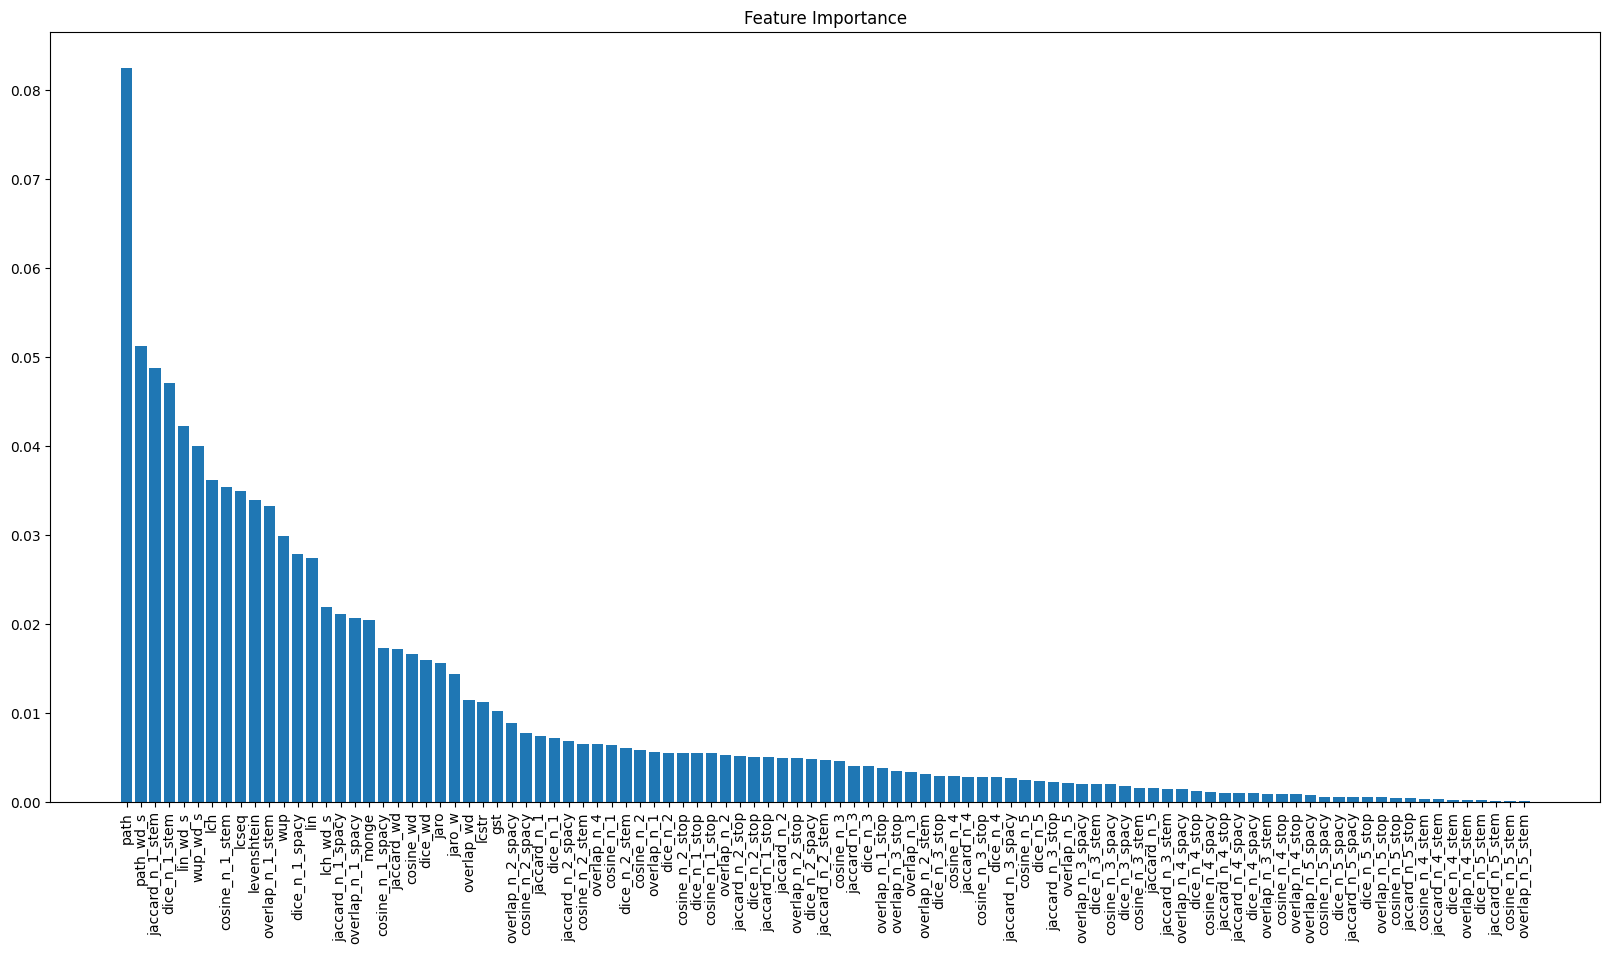

In [37]:
plot_feature_importances(rf_gscv.best_estimator_['model'], X_train)

#### Test Results

In [38]:
y_pred = rf_gscv.predict(X_test)
print("Pearson correlation between predicted and true values: {:.4f}".format(pearsonr(y_pred, y_test)[0]))
y_pred_onwn = rf_gscv.predict(X_test[df_test['file'] == "surprise.OnWN"])
y_onwn = y_test[df_test['file'] == "surprise.OnWN"]

print("OnWN: Pearson correlation between predicted and true values: {:.4f}".format(pearsonr(y_pred_onwn, y_onwn)[0]))

y_pred = rf_gscv.predict(X_test)
y_pred_smt = rf_gscv.predict(X_test[df_test['file'] == "surprise.SMTnews"])
y_smt = y_test[df_test['file'] == "surprise.SMTnews"]

print("SMTnews: Pearson correlation between predicted and true values: {:.4f}".format(pearsonr(y_pred_smt, y_smt)[0]))

Pearson correlation between predicted and true values: 0.7371
OnWN: Pearson correlation between predicted and true values: 0.6920
SMTnews: Pearson correlation between predicted and true values: 0.4754


## Individual Models

As it was shown in the Analysis section, the distribution of the similarity scores is completely different for each dataset. This suggests that individual models should be trained for each dataset. In this section, we will train a model for each dataset.

### MSRpar

In [39]:
# Random Forest
df_train_par = df_train[df_train['file'] == "MSRpar"]
X_train_par = df_train_par.drop(columns=["gs", "file"])
y_train_par = df_train_par["gs"]

df_test_par = df_test[df_test['file'] == "MSRpar"]
X_test_par = df_test_par.drop(columns=["gs", "file"])
y_test_par = df_test_par["gs"]

# Fix the random state
rf = RandomForestRegressor(random_state=42)
forest_param_grid = {'model__n_estimators': np.arange(100, 500, 50), 
                     'model__min_samples_leaf': [2, 4, 6, 8, 10],
                        'model__max_features': ['sqrt', 'log2'],
                        # 'model__max_depth' : [None, 4, 6, 8, 10],
                    'model__n_jobs': [-1]}

rf_gscv_par = train_and_test(rf, forest_param_grid, X_train_par, y_train_par)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 1/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 2/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 3/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 4/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 5/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 6/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 7/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 8/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[

The best hyperparameters for the model are:
- n_estimators: 250
- min_samples_leaf: 6
- max_features: log2

Leading to a score of 0.66 in 10-fold Cross Validation

In [40]:
pd.DataFrame(rf_gscv_par.cv_results_).sort_values(by='rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
59       0.664307      0.030380         0.072051        0.022053   
58       0.573029      0.035320         0.066121        0.015142   
60       0.800768      0.039253         0.074194        0.010666   
57       0.425628      0.026709         0.055289        0.010244   
61       0.983488      0.045141         0.087974        0.012011   

   param_model__max_features param_model__min_samples_leaf  \
59                      log2                             6   
58                      log2                             6   
60                      log2                             6   
57                      log2                             6   
61                      log2                             6   

   param_model__n_estimators param_model__n_jobs  \
59                       250                  -1   
58                       200                  -1   
60                       300                  -1   
57                       150                  -1   
61                       350                  -1   

                                               params  split0_test_score  \
59  {'model__max_features': 'log2', 'model__min_sa...           0.636422   
58  {'model__max_features': 'log2', 'model__min_sa...           0.639559   
60  {'model__max_features': 'log2', 'model__min_sa...           0.638932   
57  {'model__max_features': 'log2', 'model__min_sa...           0.640194   
61  {'model__max_features': 'log2', 'model__min_sa...           0.636646   

    split1_test_score  split2_test_score  split3_test_score  \
59           0.624321           0.652165           0.645850   
58           0.624805           0.653942           0.644756   
60           0.621388           0.651648           0.643375   
57           0.618852           0.655941           0.642481   
61           0.619552           0.650381           0.640842   

    split4_test_score  split5_test_score  split6_test_score  \
59           0.590570           0.664996           0.627212   
58           0.586192           0.664258           0.626019   
60           0.589276           0.665204           0.626866   
57           0.587690           0.661131           0.625765   
61           0.587512           0.666527           0.628374   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
59           0.763603           0.723567           0.719750         0.664845   
58           0.763139           0.720739           0.717972         0.664138   
60           0.759182           0.723958           0.717935         0.663777   
57           0.762850           0.719510           0.717963         0.663238   
61           0.758827           0.725293           0.717961         0.663191   

    std_test_score  rank_test_score  
59        0.051108                1  
58        0.051051                2  
60        0.050546                3  
57        0.051172                4  
61        0.051211                5

#### Feature Importance and Test Results

In [41]:
y_pred_par = rf_gscv_par.predict(X_test_par)

print("MSRpar: Pearson correlation between predicted and true values: {:.2f}".format(pearsonr(y_pred_par, y_test_par)[0]))

MSRpar: Pearson correlation between predicted and true values: 0.65


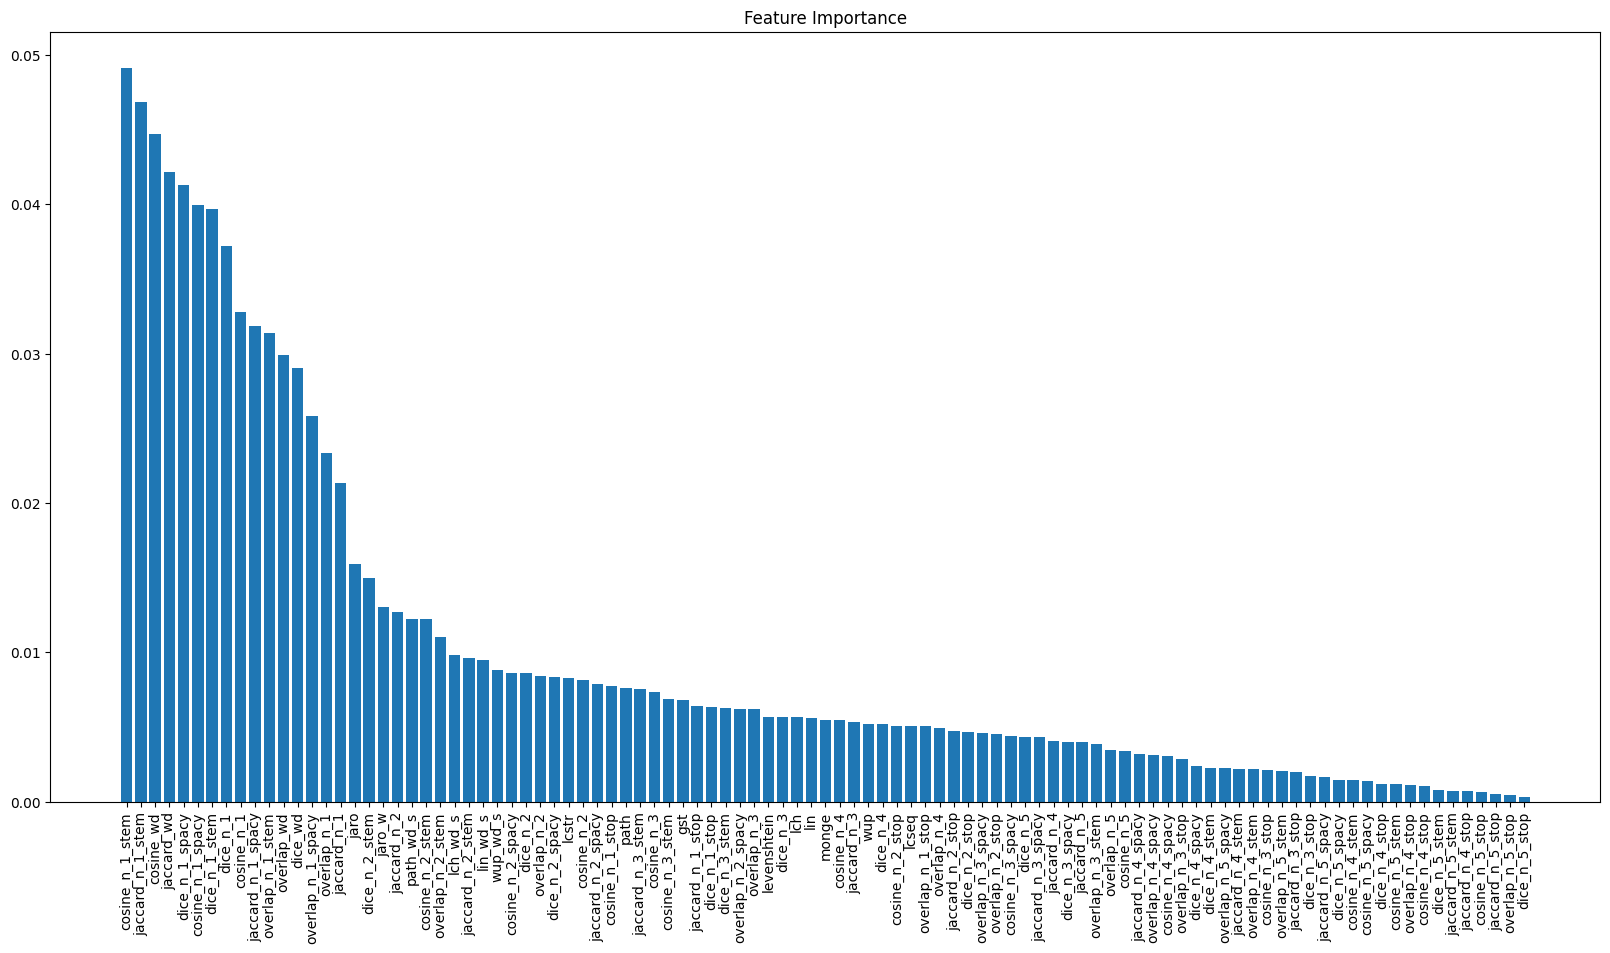

In [42]:
plot_feature_importances(rf_gscv_par.best_estimator_['model'], X_train)

Word similarity (with and without disambiguation) and semantic similarity features are the most important ones. This makes sense as the sentences are paraphrases of each other. The most important simmilarity measures are `cosine` and `jaccard`.

### MSRvid

In [43]:
# Random Forest
df_train_vid = df_train[df_train['file'] == "MSRvid"]
X_train_vid = df_train_vid.drop(columns=["gs", "file"])
y_train_vid = df_train_vid["gs"]

df_test_vid = df_test[df_test['file'] == "MSRvid"]
X_test_vid = df_test_vid.drop(columns=["gs", "file"])
y_test_vid = df_test_vid["gs"]

# Fix the random state
rf = RandomForestRegressor(random_state=42)
forest_param_grid = {'model__n_estimators': np.arange(100, 500, 50), 
                     'model__min_samples_leaf': [2, 4, 6, 8, 10],
                        'model__max_features': ['sqrt', 'log2'],
                        # 'model__max_depth' : [None, 4, 6, 8, 10],
                    'model__n_jobs': [-1]}

rf_gscv_vid = train_and_test(rf, forest_param_grid, X_train_vid, y_train_vid)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 1/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 2/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 3/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 4/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 5/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 6/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 7/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 8/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[

Best hyperparameters:
- n_estimators: 100
- min_samples_leaf: 2
- max_features: sqrt

These hyperparameters can mean that the model is trying to overfit the data. However, the results are good and match with what's obtained in the test set.

#### Feature Importance and Test Results

In [67]:
y_pred_vid = rf_gscv_vid.predict(X_test_vid)

print("MSRvid: Pearson correlation between predicted and true values: {:.2f}".format(pearsonr(y_pred_vid, y_test_vid)[0]))

MSRvid: Pearson correlation between predicted and true values: 0.85


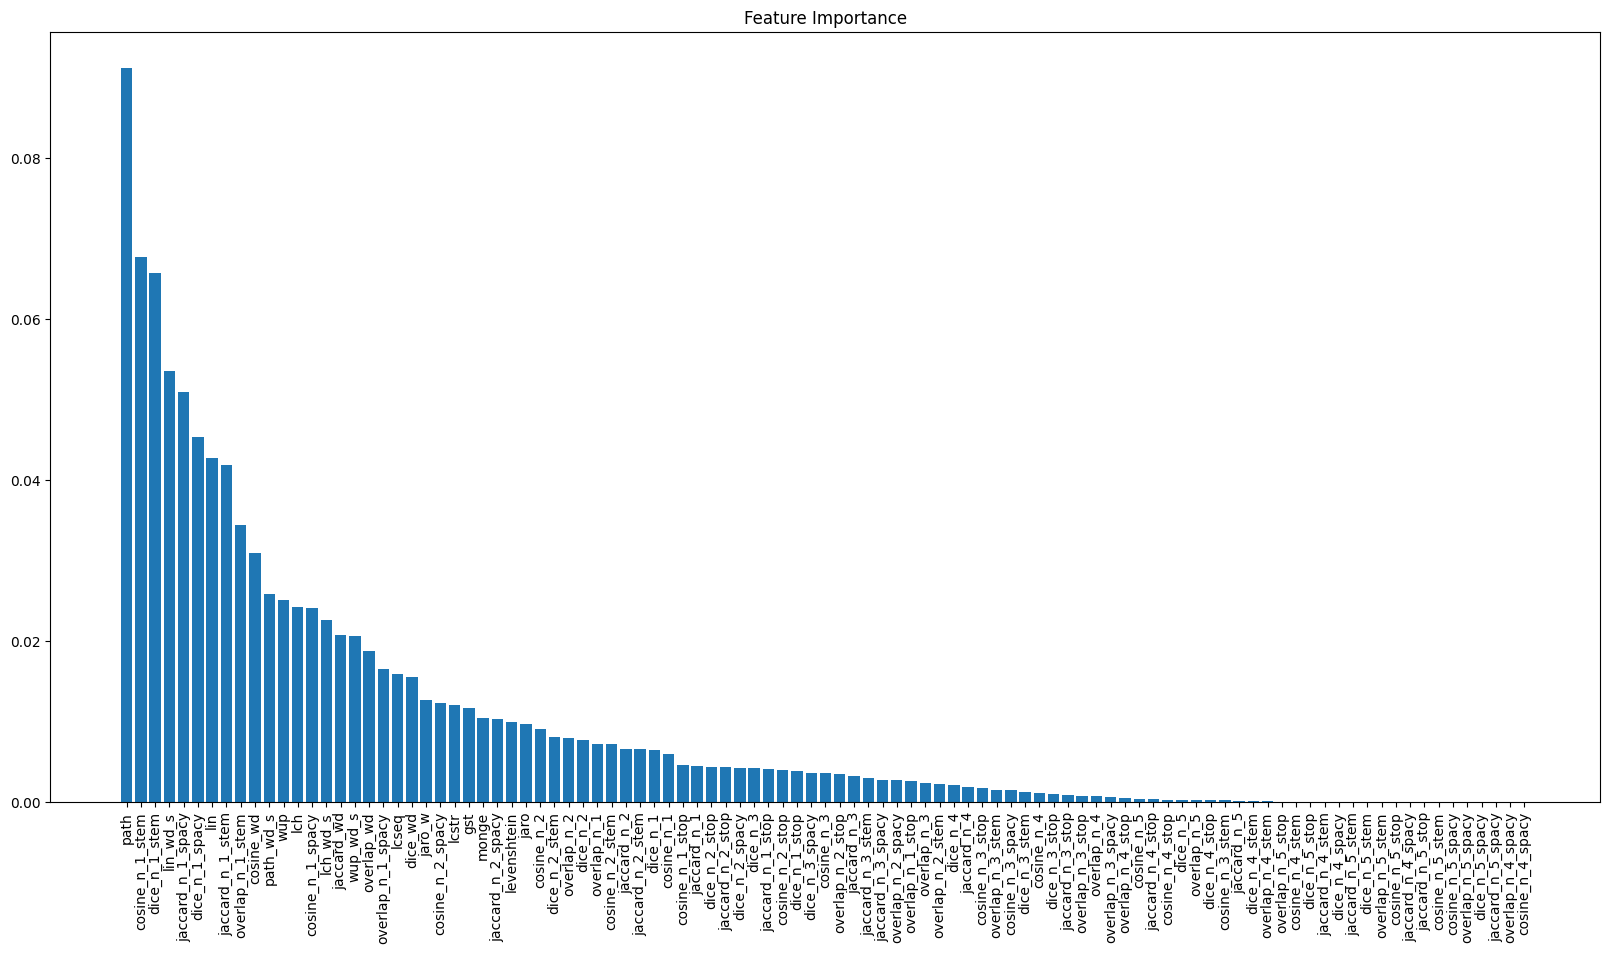

In [45]:
plot_feature_importances(rf_gscv_vid.best_estimator_['model'], X_train)

In this case, path similarity is the most important feature. This makes sense as the sentences are descriptions of the same video and the words used are similar.

### SMTeuroparl

In [46]:
# Random Forest
df_train_eur = df_train[df_train['file'] == "SMTeuroparl"]
X_train_eur = df_train_eur.drop(columns=["gs", "file"])
y_train_eur = df_train_eur["gs"]

df_test_eur = df_test[df_test['file'] == "SMTeuroparl"]
X_test_eur = df_test_eur.drop(columns=["gs", "file"])
y_test_eur = df_test_eur["gs"]

# Fix the random state
rf = RandomForestRegressor(random_state=42)
forest_param_grid = {'model__n_estimators': np.arange(100, 500, 50), 
                     'model__min_samples_leaf': [2, 4, 6, 8, 10],
                        'model__max_features': ['sqrt', 'log2'],
                        # 'model__max_depth' : [None, 4, 6, 8, 10],
                    'model__n_jobs': [-1]}

rf_gscv_eur = train_and_test(rf, forest_param_grid, X_train_eur, y_train_eur)

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 1/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 2/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 3/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 4/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 5/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 6/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 7/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 8/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[

The best hyperparameters for the model are:
- n_estimators: 300
- min_samples_leaf: 2
- max_features: log2

In [47]:
pd.DataFrame(rf_gscv_eur.cv_results_).sort_values(by='rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
44       1.123243      0.036543         0.098522        0.021966   
42       0.763198      0.037967         0.074393        0.011557   
43       0.936519      0.036783         0.085269        0.020880   
45       1.271054      0.037184         0.090457        0.010059   
6        1.742547      0.048743         0.124210        0.026957   

   param_model__max_features param_model__min_samples_leaf  \
44                      log2                             2   
42                      log2                             2   
43                      log2                             2   
45                      log2                             2   
6                       sqrt                             2   

   param_model__n_estimators param_model__n_jobs  \
44                       300                  -1   
42                       200                  -1   
43                       250                  -1   
45                       350                  -1   
6                        400                  -1   

                                               params  split0_test_score  \
44  {'model__max_features': 'log2', 'model__min_sa...           0.704164   
42  {'model__max_features': 'log2', 'model__min_sa...           0.703283   
43  {'model__max_features': 'log2', 'model__min_sa...           0.700020   
45  {'model__max_features': 'log2', 'model__min_sa...           0.702974   
6   {'model__max_features': 'sqrt', 'model__min_sa...           0.704377   

    split1_test_score  split2_test_score  split3_test_score  \
44           0.641777           0.827102           0.901272   
42           0.642286           0.825981           0.899324   
43           0.642070           0.825840           0.900402   
45           0.640290           0.826691           0.902074   
6            0.623794           0.825343           0.904218   

    split4_test_score  split5_test_score  split6_test_score  \
44           0.724515           0.405031           0.586097   
42           0.723597           0.404557           0.580894   
43           0.721811           0.405578           0.581602   
45           0.722926           0.403448           0.581891   
6            0.723557           0.398222           0.584176   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
44           0.770535           0.513168           0.810204         0.688387   
42           0.769388           0.521113           0.808666         0.687909   
43           0.766557           0.521402           0.809214         0.687450   
45           0.770142           0.514023           0.807098         0.687156   
6            0.765314           0.519629           0.816156         0.686479   

    std_test_score  rank_test_score  
44        0.145373                1  
42        0.144269                2  
43        0.143948                3  
45        0.145672                4  
6         0.147223                5

#### Feature Importance and Test Results

In [48]:
y_pred_eur = rf_gscv_eur.predict(X_test_eur)

print("SMTeuroparl: Pearson correlation between predicted and true values: {:.2f}".format(pearsonr(y_pred_eur, y_test_eur)[0]))

SMTeuroparl: Pearson correlation between predicted and true values: 0.37


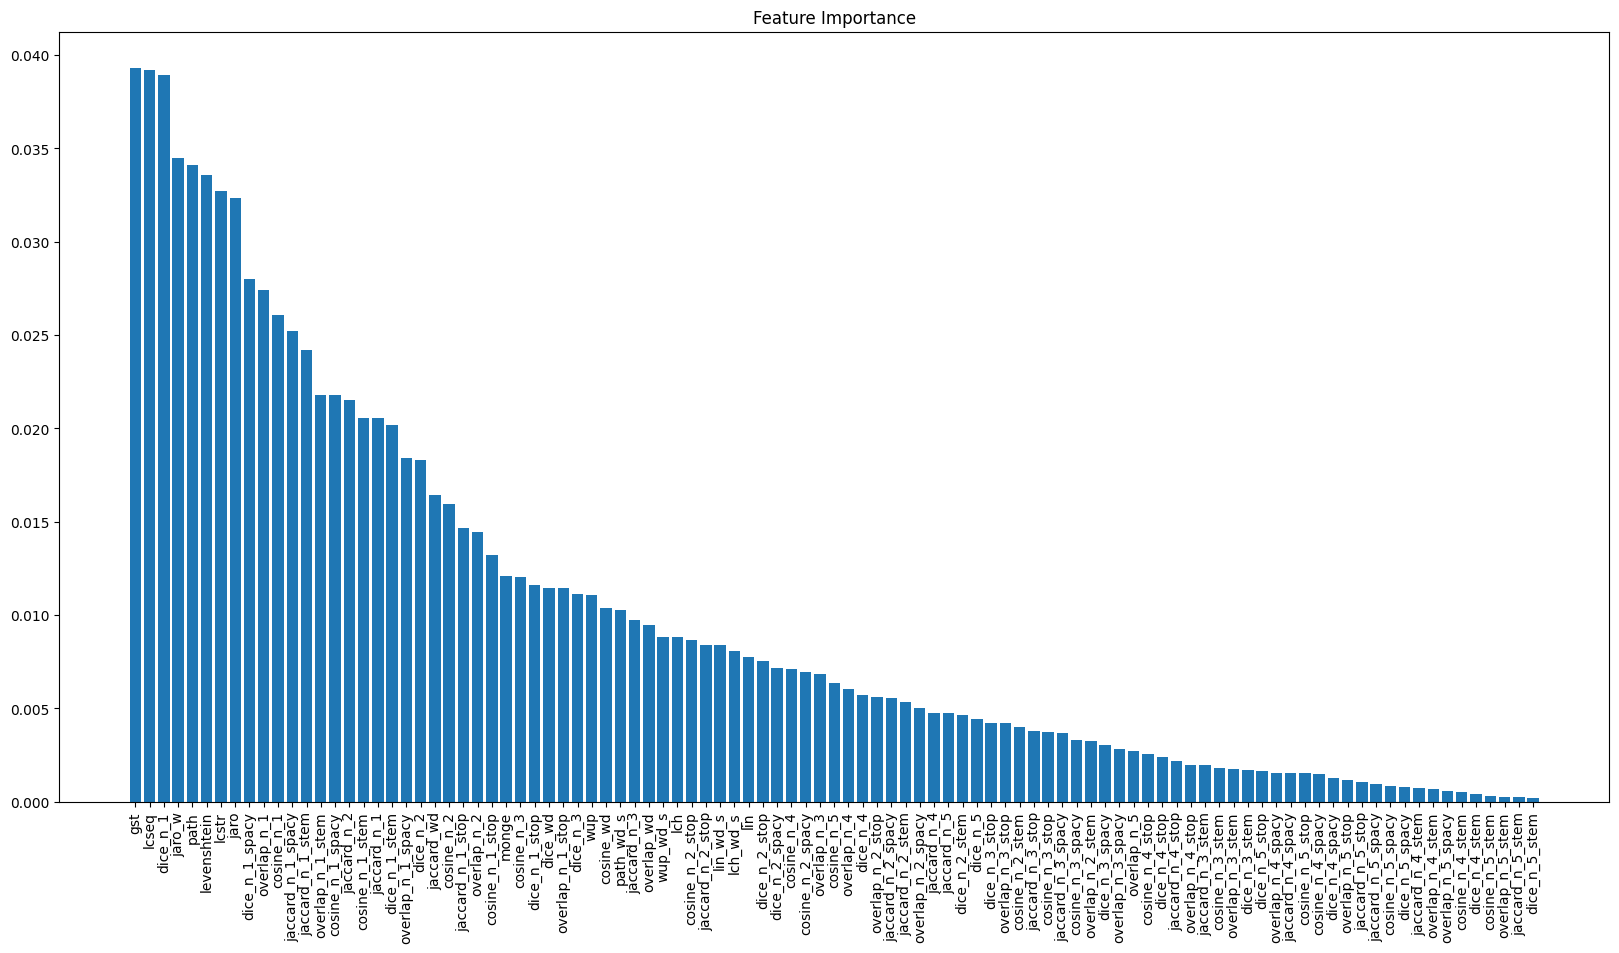

In [49]:
plot_feature_importances(rf_gscv_eur.best_estimator_['model'], X_train_eur)

### Join all models

As mentioned before, the distribution of the similarity scores is completely different for each dataset. This suggests that individual models should be trained for each dataset. 

It's possible to compare the results of the individual models with the results of the model trained with all the datasets in training set. The results are shown in the following table:

In [68]:
ls_files = ["MSRpar", "MSRvid", "SMTeuroparl"]
ls_models = [rf_gscv_par, rf_gscv_vid, rf_gscv_eur]
ls_cols = [X_train_par.columns, X_train_vid.columns, X_train_eur.columns]
orig_cols = X_train.columns

df_comp_train = pd.DataFrame()
for file, ind_model, cols in zip(ls_files, ls_models, ls_cols):
    X_train_file = df_train[df_train.file == file]
    y_train_file = X_train_file.gs
    y_total_model = rf_gscv.predict(X_train_file[orig_cols])
    y_ind_model = ind_model.predict(X_train_file[cols])

    df_comp_train.loc["IND", file] = pearsonr(y_ind_model, y_train_file).statistic
    df_comp_train.loc["COL", file] = pearsonr(y_total_model, y_train_file).statistic

df_comp_train

MSRpar    MSRvid  SMTeuroparl
IND  0.850328  0.964602     0.950103
COL  0.957073  0.965225     0.936078

In [69]:
ls_files = ["MSRpar", "MSRvid", "SMTeuroparl"]
ls_models = [rf_gscv_par, rf_gscv_vid, rf_gscv_eur]
ls_cols = [X_train_par.columns, X_train_vid.columns, X_train_eur.columns]
orig_cols = X_train.columns

df_comp_test = pd.DataFrame()
for file, ind_model, cols in zip(ls_files, ls_models, ls_cols):
    X_test_file = df_test[df_test.file == file]
    y_test_file = X_test_file.gs
    y_total_model = rf_gscv.predict(X_test_file[orig_cols])
    y_ind_model = ind_model.predict(X_test_file[cols])

    df_comp_test.loc["IND", file] = pearsonr(y_ind_model, y_test_file).statistic
    df_comp_test.loc["COL", file] = pearsonr(y_total_model, y_test_file).statistic

df_comp_test

MSRpar    MSRvid  SMTeuroparl
IND  0.649206  0.847945     0.367519
COL  0.634591  0.851877     0.551934

The number of columns for each dataset is 99 in all the cases. However, we said that the distributions are different and from Random Forest feature importance we can see that the most important features are different for each dataset. This means that the model trained with all the datasets is not using the most important features for each dataset. This is the reason why the results are worse than the individual models.

In [74]:
{file:len(cols) for file, cols in zip(ls_files, ls_cols)}

{'MSRpar': 99, 'MSRvid': 99, 'SMTeuroparl': 99}

In [105]:
y_out_total = np.concatenate([y_test_par, y_test_vid, y_test_eur, y_onwn, y_smt])
y_pred_total = np.concatenate([y_pred_par, y_pred_vid, y_pred_eur, y_pred_onwn, y_pred_smt])

total_corr = pearsonr(y_pred_total, y_out_total)[0]
print("Total: Pearson correlation between predicted and true values: {:.4f}".format(total_corr))

Total: Pearson correlation between predicted and true values: 0.7767


In [107]:
# Autoscaled correlation (ALLNORM) using Ridge
from sklearn.linear_model import RidgeCV

ls_preds = [y_pred_par, y_pred_vid, y_pred_eur, y_pred_onwn, y_pred_smt]
ls_true = [y_test_par, y_test_vid, y_test_eur, y_onwn, y_smt]

def get_allnorm_corr(ls_preds, ls_true):
    reg = RidgeCV(alphas=np.logspace(-6, 6, 13), cv=10)
    arr_preds = np.concatenate(ls_preds)
    arr_true = np.concatenate(ls_true)    

    reg.fit(arr_preds.reshape(-1, 1), arr_true)
    corr = pearsonr(reg.predict(arr_preds.reshape(-1, 1)).ravel(), arr_true).statistic
    print("ALLNORM: Pearson correlation between predicted and true values: {:.4f}".format(corr))
    print("ALLNORM: beta1: {:.4f}, beta2 {:.4f} ".format(reg.coef_[0], reg.intercept_))
    return corr

allnorm_corr = get_allnorm_corr(ls_preds, ls_true)

# Weighted mean correlation (ALLNORM)

def get_weighted_mean_corr(ls_preds, ls_true):
    weighted_mean = np.sum([pearsonr(y_pred, y_true).statistic * len(y_pred) / len(df_test)  for y_pred, y_true in zip(ls_preds, ls_true)])
    print("WEIGHTED: Weighted mean correlation between predicted and true values: {:.4f}".format(weighted_mean))
    return weighted_mean

weighted_mean = get_weighted_mean_corr(ls_preds, ls_true)

ALLNORM: Pearson correlation between predicted and true values: 0.7767
ALLNORM: beta1: 0.8869, beta2 0.7338 
WEIGHTED: Weighted mean correlation between predicted and true values: 0.6436


In [108]:
# Analitycal correlation (ALLNORM)
# import numpy as np
# from scipy.stats import pearsonr

# # Concatenate system scores
# X = np.concatenate(ls_preds)

# # Gold standard scores
# Y = np.concatenate(ls_true)

# # Linear transformation to minimize squared error
# beta1 = np.cov(X, Y)[0, 1] / np.var(X)
# beta2 = np.mean(Y) - beta1 * np.mean(X)

# # Apply linear transformation to get normalized system scores
# X0 = X * beta1 + beta2

# # Compute Pearson correlation (ALLnorm)
# pearson_corr, _ = pearsonr(X0, Y)

# print(f"Normalized Pearson Correlation (ALLnorm): {pearson_corr}")


In [109]:
# Dataframe with results
df_results = pd.DataFrame(columns=["ALL", "ALLNORM", "WEIGHTED"])
df_results.loc[0, "ALL"] = total_corr
df_results.loc[0, "ALLNORM"] = allnorm_corr
df_results.loc[0, "WEIGHTED"] = weighted_mean
df_results

ALL   ALLNORM  WEIGHTED
0  0.776656  0.776656  0.643581

ALL and ALLNORM are the same because the regression is not sensitive to the scale of the variables.

# Model Selection #2 -> Reduce the number of features

As we mentioned during the analysis, the amount of features is really high. This is the reason why feature selection technique will be used. The benefits of reducing the number of features are:
- Reduce the training time
- Reduce the risk of overfitting
- Reduce the complexity of the model
- Reduce the risk of multicollinearity
- Reduce the risk of curse of dimensionality

Apart from that, in real life, it is not possible to have all the features or the economic cost of having all the features is too high. This is the reason why it is important to select the best features.

In general, filter methods such as correlation, chi2, ANOVA, ... are used to select the best features and they are efficient but not very accurate. In the other side, wrapping methods like Recursive Feature Elimination (RFE) or Sequential Feature Selection (SFS) are more accurate but they are computationally expensive. 

In this case, we will use a hybrid method which combines the advantages of both methods. The method is doing feature selection by using Lasso regression. The idea is that Lasso regression will select the best features and then a Random Forest will be trained using only those features. The advantage of this method is that it is computationally efficient and it is more accurate than filter methods.

In [22]:
# Create function to plot lasso coefficients
def plot_lasso_coef(model, X_train, figsize=(20, 10)):
    coef = pd.Series(model.best_estimator_.named_steps['model'].coef_, index=X_train.columns)
    coef = coef.sort_values()
    plt.figure(figsize=figsize)
    coef.plot(kind='barh')
    plt.title('Lasso coefficients')
    plt.show()

## All Datasets

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


[CV 10/10; 1/100] START model__alpha=1e-05......................................
[CV 2/10; 1/100] START model__alpha=1e-05.......................................
[CV 3/10; 1/100] START model__alpha=1e-05.......................................
[CV 4/10; 1/100] START model__alpha=1e-05.......................................
[CV 1/10; 2/100] START model__alpha=0.00011090909090909092......................
[CV 1/10; 1/100] START model__alpha=1e-05.......................................
[CV 6/10; 1/100] START model__alpha=1e-05.......................................
[CV 7/10; 2/100] START model__alpha=0.00011090909090909092......................
[CV 5/10; 1/100] START model__alpha=1e-05.......................................
[CV 9/10; 2/100] START model__alpha=0.00011090909090909092......................
[CV 7/10; 1/100] START model__alpha=1e-05.......................................
[CV 3/10; 2/100] START model__alpha=0.00011090909090909092......................
[CV 1/10; 3/100] START model

/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.031e+01, tolerance: 4.294e+01
  model = cd_fast.enet_coordinate_descent(


[CV 4/10; 1/100] END ........model__alpha=1e-05;, score=0.702 total time=  10.3s


/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.051e+01, tolerance: 4.489e+01
  model = cd_fast.enet_coordinate_descent(
/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.801e+01, tolerance: 3.991e+01
  model = cd_fast.enet_coordinate_descent(


[CV 1/10; 1/100] END ........model__alpha=1e-05;, score=0.601 total time=  10.5s
[CV 5/10; 1/100] END ........model__alpha=1e-05;, score=0.760 total time=  10.7s
[CV 3/10; 1/100] END ........model__alpha=1e-05;, score=0.562 total time=  10.7s


/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.990e+01, tolerance: 3.659e+01
  model = cd_fast.enet_coordinate_descent(


[CV 6/10; 1/100] END ........model__alpha=1e-05;, score=0.753 total time=  10.9s


/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.630e+01, tolerance: 4.271e+01
  model = cd_fast.enet_coordinate_descent(


[CV 10/10; 1/100] END .......model__alpha=1e-05;, score=0.523 total time=  11.1s


/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.053e+01, tolerance: 4.493e+01
  model = cd_fast.enet_coordinate_descent(


[CV 2/10; 1/100] END ........model__alpha=1e-05;, score=0.631 total time=  12.5s


/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.857e+01, tolerance: 4.680e+01
  model = cd_fast.enet_coordinate_descent(


Best cross-validation score: 0.66
Best parameters: {'model__alpha': 1e-05}


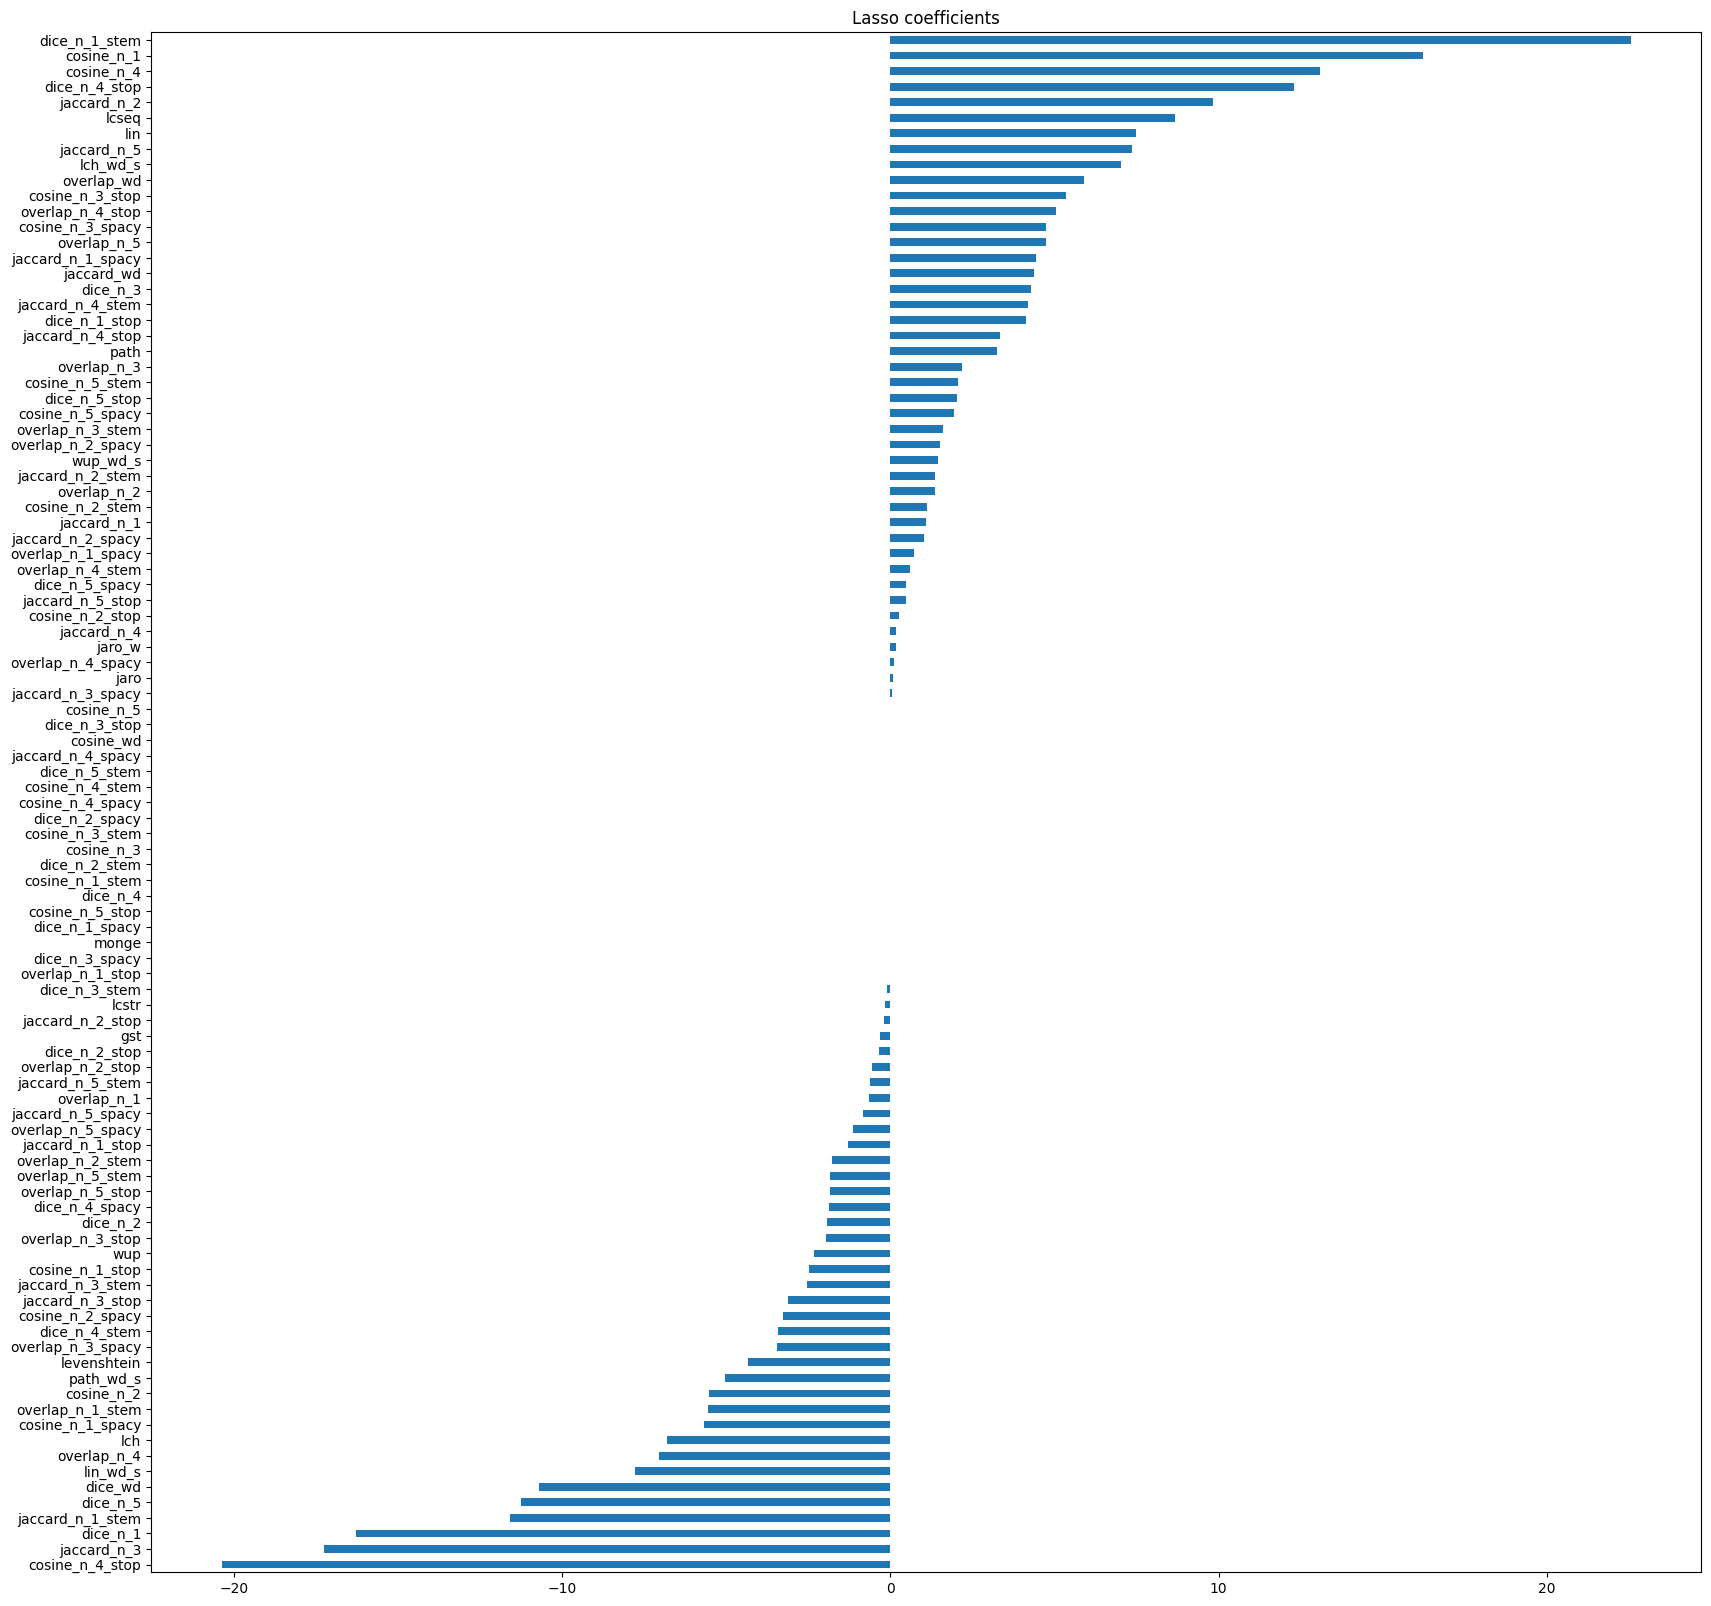

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 1/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 4/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 8/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 4/10; 2/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=150, model__n_jobs=-1
[CV 6/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 2/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 3/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 5/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[

In [24]:
# wd_cols = [col for col in df_train.columns if "_wd" in col]
X_train = df_train.drop(columns=["gs"])
y_train = df_train["gs"]
X_test = df_test.drop(columns=["gs"])
y_test = df_test["gs"]
X_train_par = X_train[X_train.file == "MSRpar"].drop(columns=["file"])
y_train_par = y_train[X_train.file == "MSRpar"]
X_test_par = X_test[X_test.file == "MSRpar"].drop(columns=["file"])
y_test_par = y_test[X_test.file == "MSRpar"]
X_train_vid = X_train[X_train.file == "MSRvid"].drop(columns=["file"])
y_train_vid = y_train[X_train.file == "MSRvid"]
X_test_vid = X_test[X_test.file == "MSRvid"].drop(columns=["file"])
y_test_vid = y_test[X_test.file == "MSRvid"]
X_train_eur = X_train[X_train.file == "SMTeuroparl"].drop(columns=["file"])
y_train_eur = y_train[X_train.file == "SMTeuroparl"]
X_test_eur = X_test[X_test.file == "SMTeuroparl"].drop(columns=["file"])
y_test_eur = y_test[X_test.file == "SMTeuroparl"]

X_train = X_train.drop(columns=["file"])
X_test = X_test.drop(columns=["file"])

model = Lasso(max_iter=100000, tol=0.01, random_state=0)
grid = {'model__alpha': np.linspace(0.00001, 0.01, 100),}


lasso_gscv = train_and_test(model, grid, X_train, y_train, scaler=MinMaxScaler())

plot_lasso_coef(lasso_gscv, X_train, (20, 20))

pos_coef = lasso_gscv.best_estimator_.named_steps['model'].coef_ != 0
pos_coef = X_train.columns[pos_coef]

X_train_pos = X_train[pos_coef]
X_test_pos = X_test[pos_coef]

# Fix the random state
rf = RandomForestRegressor(random_state=42)
forest_param_grid = {'model__n_estimators': np.arange(100, 500, 50), 
                     'model__min_samples_leaf': [2, 4, 6, 8, 10],
                        'model__max_features': ['sqrt', 'log2'],
                        # 'model__max_depth' : [None, 4, 6, 8, 10],
                    'model__n_jobs': [-1]}
rf_gscv_pos = train_and_test(rf, forest_param_grid, X_train_pos, y_train)


In [37]:
print("Number of features reduced to: ", len(pos_coef))

Number of features reduced to:  82


In [25]:
pd.DataFrame(rf_gscv_pos.cv_results_).sort_values(by='rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
42       1.254794      0.044118         0.090727        0.013463   
44       1.882135      0.080565         0.115677        0.018793   
47       2.734980      0.072863         0.129734        0.022849   
46       2.504833      0.113567         0.129673        0.028546   
45       2.195074      0.068359         0.144364        0.023269   

   param_model__max_features param_model__min_samples_leaf  \
42                      log2                             2   
44                      log2                             2   
47                      log2                             2   
46                      log2                             2   
45                      log2                             2   

   param_model__n_estimators param_model__n_jobs  \
42                       200                  -1   
44                       300                  -1   
47                       450                  -1   
46                       400                  -1   
45                       350                  -1   

                                               params  split0_test_score  \
42  {'model__max_features': 'log2', 'model__min_sa...           0.634071   
44  {'model__max_features': 'log2', 'model__min_sa...           0.634203   
47  {'model__max_features': 'log2', 'model__min_sa...           0.634981   
46  {'model__max_features': 'log2', 'model__min_sa...           0.634572   
45  {'model__max_features': 'log2', 'model__min_sa...           0.632146   

    split1_test_score  split2_test_score  split3_test_score  \
42           0.608668           0.614361           0.722866   
44           0.608472           0.610329           0.724465   
47           0.607405           0.610459           0.724061   
46           0.607021           0.608623           0.723902   
45           0.608045           0.608951           0.723729   

    split4_test_score  split5_test_score  split6_test_score  \
42           0.808526           0.826746           0.906636   
44           0.807248           0.827874           0.907445   
47           0.807332           0.829878           0.906996   
46           0.807871           0.828997           0.907577   
45           0.807586           0.827714           0.907949   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
42           0.724464           0.690244           0.661252         0.719783   
44           0.723491           0.694690           0.657837         0.719606   
47           0.723337           0.695501           0.655721         0.719567   
46           0.723599           0.693091           0.656865         0.719212   
45           0.724052           0.694096           0.657831         0.719210   

    std_test_score  rank_test_score  
42        0.094534                1  
44        0.095261                2  
47        0.095567                3  
46        0.095909                4  
45        0.095782                5

### Feature Importance and Test Results

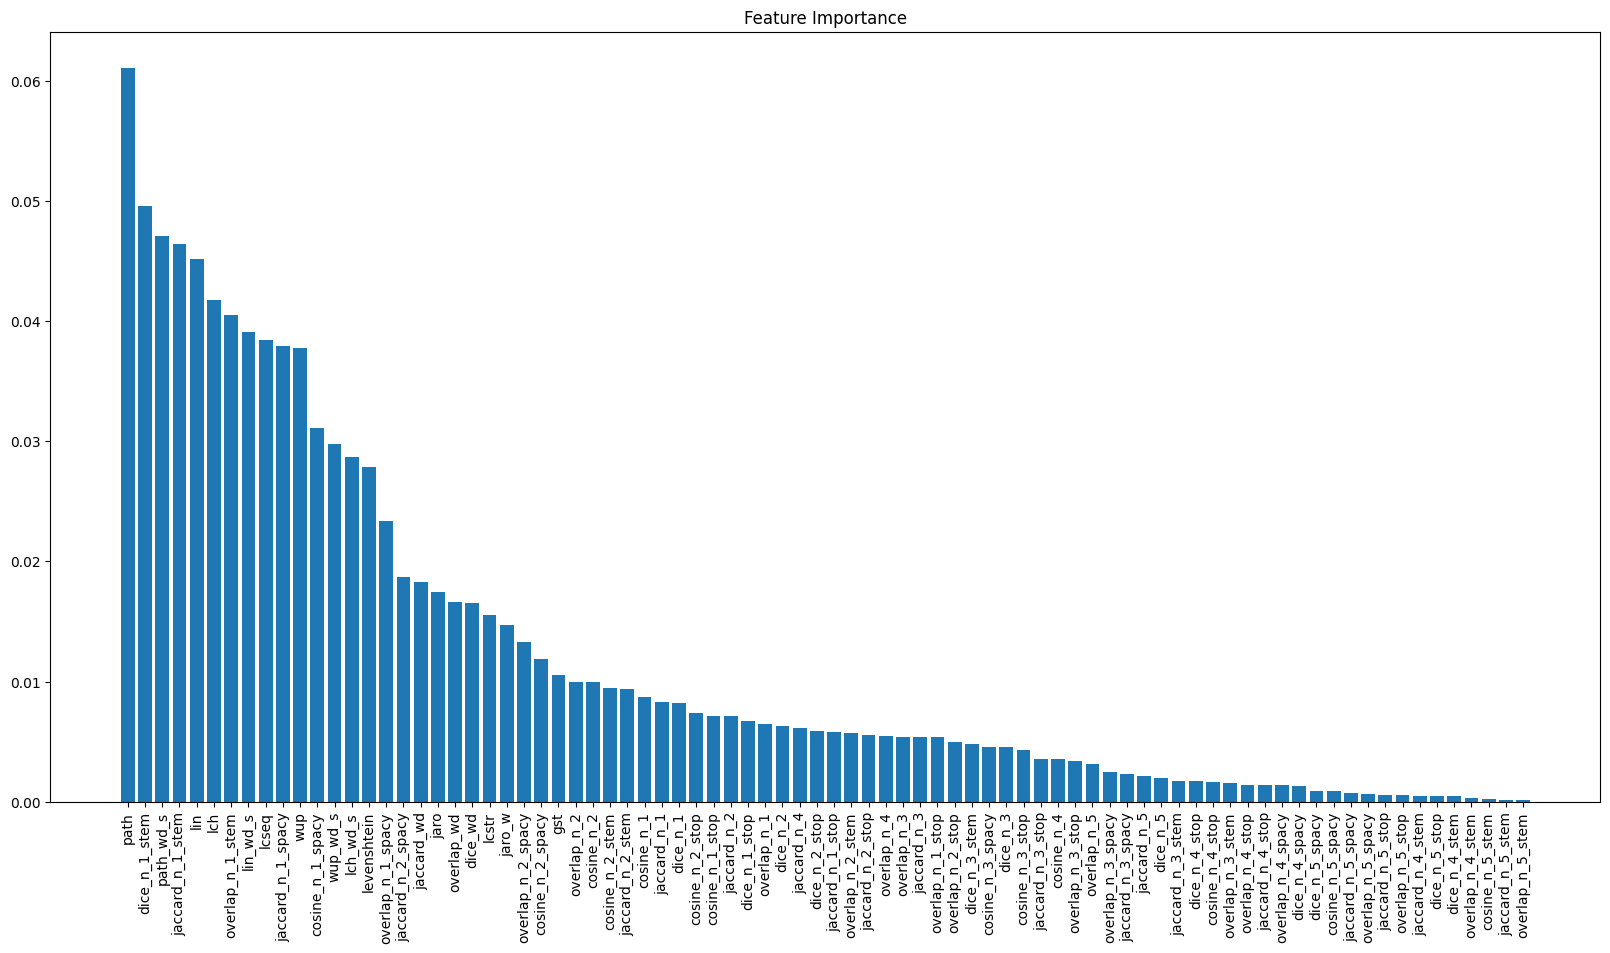

Pearson correlation between predicted and true values: 0.7316
OnWN: Pearson correlation between predicted and true values: 0.6855
SMTnews: Pearson correlation between predicted and true values: 0.5045


In [26]:
plot_feature_importances(rf_gscv_pos.best_estimator_['model'], X_train_pos)

y_pred_pos = rf_gscv_pos.predict(X_test_pos)
print("Pearson correlation between predicted and true values: {:.4f}".format(pearsonr(y_pred_pos, y_test)[0]))
y_pred_onwn_pos = rf_gscv_pos.predict(X_test[df_test['file'] == "surprise.OnWN"][X_test_pos.columns])
y_onwn = y_test[df_test['file'] == "surprise.OnWN"]

print("OnWN: Pearson correlation between predicted and true values: {:.4f}".format(pearsonr(y_pred_onwn_pos, y_onwn)[0]))

y_pred_pos = rf_gscv_pos.predict(X_test_pos)
y_pred_smt_pos = rf_gscv_pos.predict(X_test[df_test['file'] == "surprise.SMTnews"][X_test_pos.columns])
y_smt = y_test[df_test['file'] == "surprise.SMTnews"]

print("SMTnews: Pearson correlation between predicted and true values: {:.4f}".format(pearsonr(y_pred_smt_pos, y_smt)[0]))

## Individual Models

### MSRpar

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10; 1/100] START model__alpha=1e-05.......................................
[CV 2/10; 1/100] START model__alpha=1e-05.......................................
[CV 3/10; 1/100] START model__alpha=1e-05.......................................
[CV 4/10; 1/100] START model__alpha=1e-05.......................................
[CV 5/10; 1/100] START model__alpha=1e-05.......................................
[CV 6/10; 1/100] START model__alpha=1e-05.......................................
[CV 7/10; 1/100] START model__alpha=1e-05.......................................
[CV 8/10; 1/100] START model__alpha=1e-05.......................................
[CV 9/10; 1/100] START model__alpha=1e-05.......................................
[CV 10/10; 1/100] START model__alpha=1e-05......................................
[CV 1/10; 2/100] START model__alpha=0.00011090909090909092......................
[CV 2/10; 2/100] START model__alpha=0.000110

/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.041e+01, tolerance: 5.770e+00
  model = cd_fast.enet_coordinate_descent(
/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.503e+01, tolerance: 5.888e+00
  model = cd_fast.enet_coordinate_descent(
/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not conv

[CV 9/10; 1/100] END ........model__alpha=1e-05;, score=0.755 total time=   3.6s
[CV 5/10; 1/100] END ........model__alpha=1e-05;, score=0.581 total time=   3.6s
[CV 1/10; 1/100] END ........model__alpha=1e-05;, score=0.692 total time=   3.7s
[CV 2/10; 1/100] END ........model__alpha=1e-05;, score=0.598 total time=   3.7s
[CV 6/10; 1/100] END ........model__alpha=1e-05;, score=0.731 total time=   3.7s
[CV 3/10; 1/100] END ........model__alpha=1e-05;, score=0.666 total time=   3.7s
[CV 10/10; 1/100] END .......model__alpha=1e-05;, score=0.744 total time=   3.8s


/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.644e+01, tolerance: 5.932e+00
  model = cd_fast.enet_coordinate_descent(


[CV 8/10; 1/100] END ........model__alpha=1e-05;, score=0.710 total time=   3.9s


/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.588e+01, tolerance: 5.886e+00
  model = cd_fast.enet_coordinate_descent(
/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.284e+00, tolerance: 5.767e+00
  model = cd_fast.enet_coordinate_descent(


[CV 4/10; 1/100] END ........model__alpha=1e-05;, score=0.704 total time=   4.4s
[CV 7/10; 1/100] END ........model__alpha=1e-05;, score=0.598 total time=   4.5s
Best cross-validation score: 0.69
Best parameters: {'model__alpha': 0.0003127272727272728}


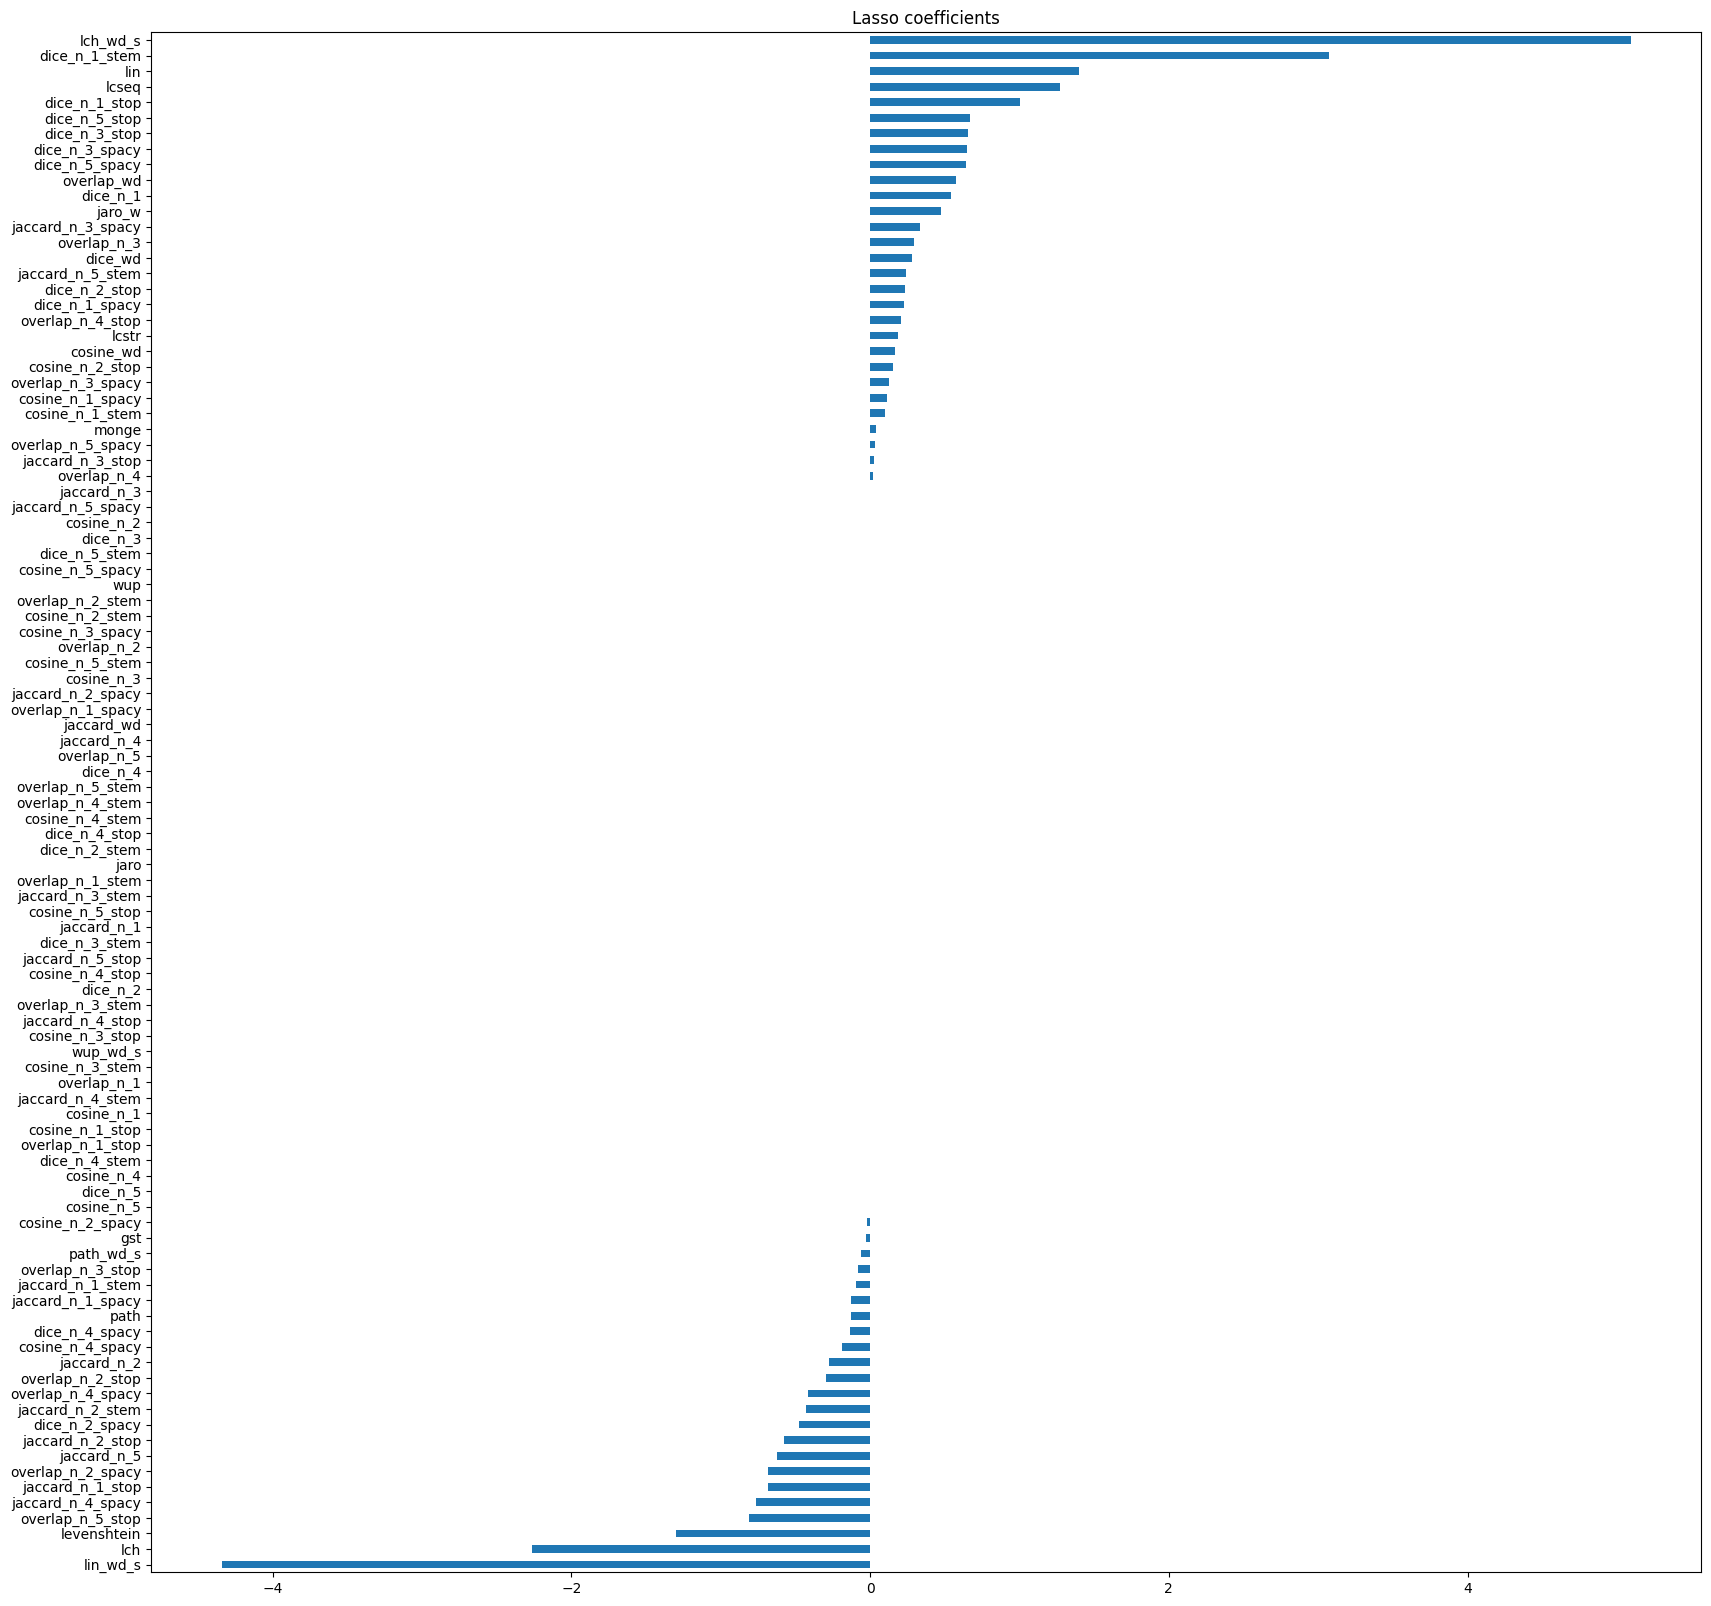

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 1/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 2/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 3/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 4/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 5/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 6/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 7/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 8/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[

In [27]:
model = Lasso(max_iter=100000, tol=0.01, random_state=0)
grid = {'model__alpha': np.linspace(0.00001, 0.01, 100),}


lasso_gscv_par = train_and_test(model, grid, X_train_par, y_train_par, scaler=MinMaxScaler())

plot_lasso_coef(lasso_gscv_par, X_train_par, (20, 20))

pos_coef_par = lasso_gscv_par.best_estimator_.named_steps['model'].coef_ != 0
pos_coef_par = X_train_par.columns[pos_coef_par]

X_train_pos_par = X_train_par[pos_coef_par]
X_test_pos_par = X_test_par[pos_coef_par]

# Fix the random state
rf = RandomForestRegressor(random_state=42)
forest_param_grid = {'model__n_estimators': np.arange(100, 500, 50), 
                     'model__min_samples_leaf': [2, 4, 6, 8, 10],
                        'model__max_features': ['sqrt', 'log2'],
                        # 'model__max_depth' : [None, 4, 6, 8, 10],
                    'model__n_jobs': [-1]}

rf_gscv_pos_par = train_and_test(rf, forest_param_grid, X_train_pos_par, y_train_par)


In [28]:
pd.DataFrame(rf_gscv_pos_par.cv_results_).sort_values(by='rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
19       0.734433      0.030168         0.066785        0.013272   
18       0.566743      0.032113         0.069269        0.016388   
20       0.909627      0.041936         0.082360        0.018069   
22       1.161832      0.040473         0.096837        0.023404   
21       1.041086      0.042398         0.074820        0.010107   

   param_model__max_features param_model__min_samples_leaf  \
19                      sqrt                             6   
18                      sqrt                             6   
20                      sqrt                             6   
22                      sqrt                             6   
21                      sqrt                             6   

   param_model__n_estimators param_model__n_jobs  \
19                       250                  -1   
18                       200                  -1   
20                       300                  -1   
22                       400                  -1   
21                       350                  -1   

                                               params  split0_test_score  \
19  {'model__max_features': 'sqrt', 'model__min_sa...           0.665533   
18  {'model__max_features': 'sqrt', 'model__min_sa...           0.662630   
20  {'model__max_features': 'sqrt', 'model__min_sa...           0.664502   
22  {'model__max_features': 'sqrt', 'model__min_sa...           0.663973   
21  {'model__max_features': 'sqrt', 'model__min_sa...           0.663642   

    split1_test_score  split2_test_score  split3_test_score  \
19           0.618688           0.658445           0.627372   
18           0.625253           0.657026           0.627096   
20           0.616127           0.656364           0.628686   
22           0.617901           0.654234           0.625408   
21           0.618182           0.654360           0.626158   

    split4_test_score  split5_test_score  split6_test_score  \
19           0.604483           0.649916           0.634399   
18           0.604049           0.649730           0.632155   
20           0.604058           0.649721           0.632934   
22           0.601837           0.652127           0.634231   
21           0.603281           0.652033           0.631467   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
19           0.750537           0.742508           0.716188         0.666807   
18           0.751031           0.738977           0.715523         0.666347   
20           0.750140           0.742474           0.718176         0.666318   
22           0.753003           0.741914           0.716217         0.666085   
21           0.751612           0.741233           0.717197         0.665916   

    std_test_score  rank_test_score  
19        0.049337                1  
18        0.048499                2  
20        0.049819                3  
22        0.050276                4  
21        0.049947                5

### Feature Importance and Test Results

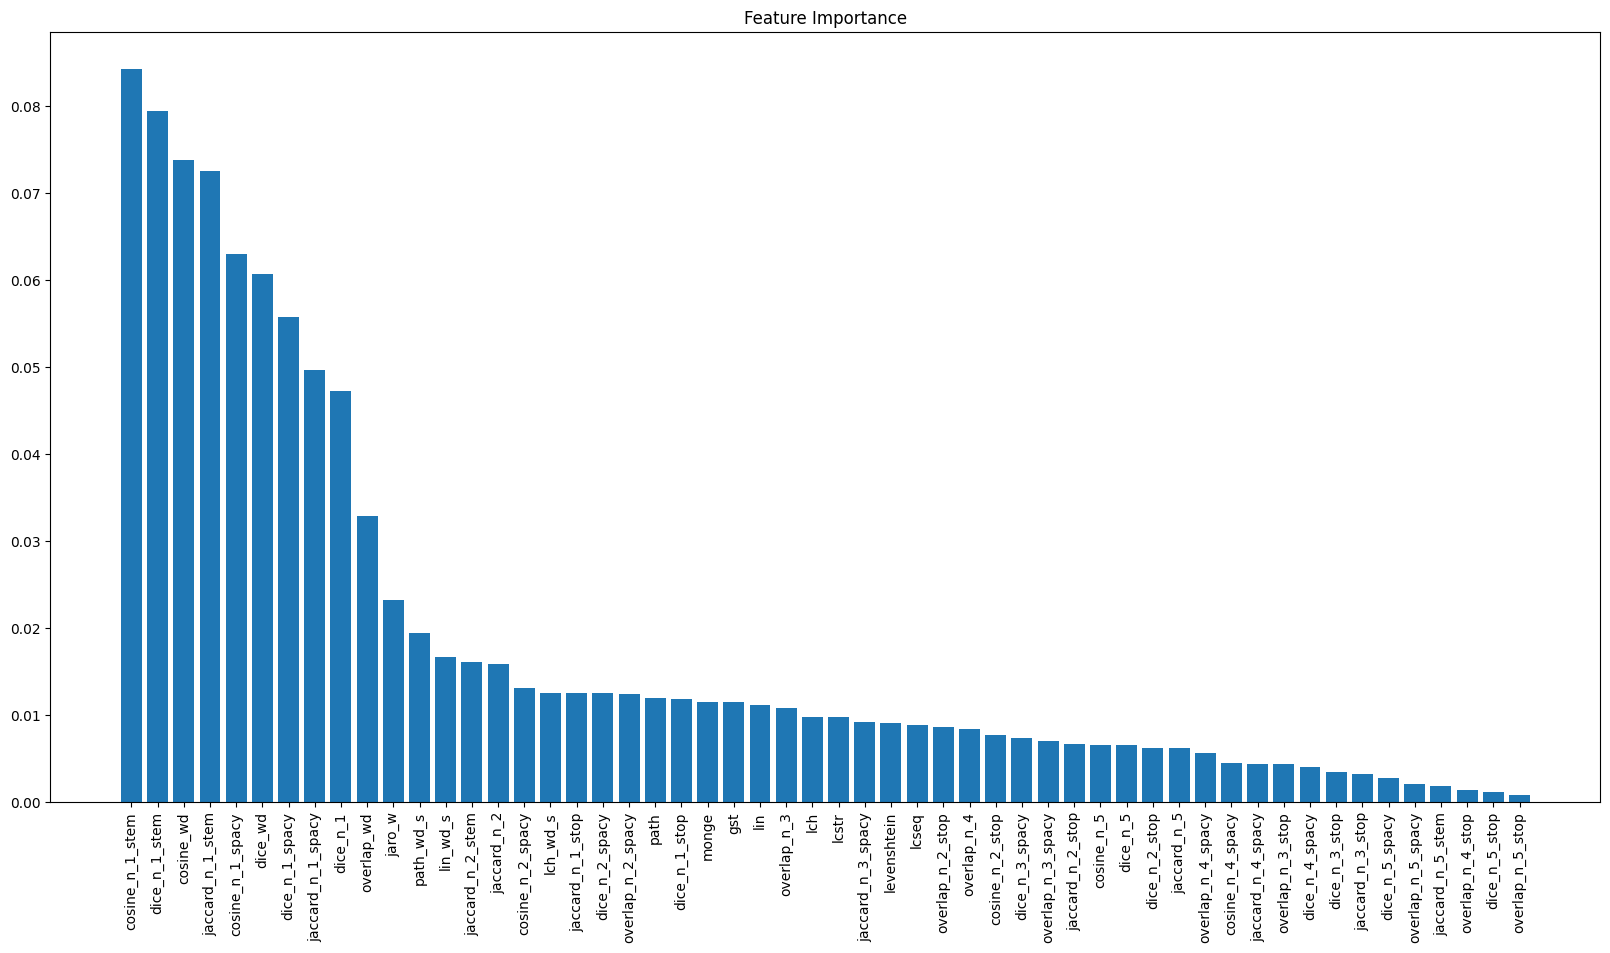

MSRpar: Pearson correlation between predicted and true values: 0.6521


In [29]:
plot_feature_importances(rf_gscv_pos_par.best_estimator_['model'], X_train_pos_par)

y_pred_pos_par = rf_gscv_pos_par.predict(X_test_pos_par)
print("MSRpar: Pearson correlation between predicted and true values: {:.4f}".format(pearsonr(y_pred_pos_par, y_test_par)[0]))

### MSRvid

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10; 1/100] START model__alpha=1e-05.......................................
[CV 2/10; 1/100] START model__alpha=1e-05.......................................
[CV 3/10; 1/100] START model__alpha=1e-05.......................................
[CV 4/10; 1/100] START model__alpha=1e-05.......................................
[CV 5/10; 1/100] START model__alpha=1e-05.......................................
[CV 6/10; 1/100] START model__alpha=1e-05.......................................
[CV 7/10; 1/100] START model__alpha=1e-05.......................................
[CV 8/10; 1/100] START model__alpha=1e-05.......................................
[CV 9/10; 1/100] START model__alpha=1e-05.......................................
[CV 10/10; 1/100] START model__alpha=1e-05......................................
[CV 1/10; 2/100] START model__alpha=0.00011090909090909092......................
[CV 2/10; 2/100] START model__alpha=0.000110

/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.061e+01, tolerance: 1.721e+01
  model = cd_fast.enet_coordinate_descent(


[CV 3/10; 1/100] END ........model__alpha=1e-05;, score=0.781 total time=   3.6s


/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.311e+01, tolerance: 1.738e+01
  model = cd_fast.enet_coordinate_descent(
/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.078e+01, tolerance: 1.737e+01
  model = cd_fast.enet_coordinate_descent(


[CV 5/10; 1/100] END ........model__alpha=1e-05;, score=0.811 total time=   3.8s
[CV 4/10; 1/100] END ........model__alpha=1e-05;, score=0.770 total time=   3.9s


/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.936e+01, tolerance: 1.699e+01
  model = cd_fast.enet_coordinate_descent(


[CV 9/10; 1/100] END ........model__alpha=1e-05;, score=0.837 total time=   4.1s
Best cross-validation score: 0.79
Best parameters: {'model__alpha': 0.003743636363636364}


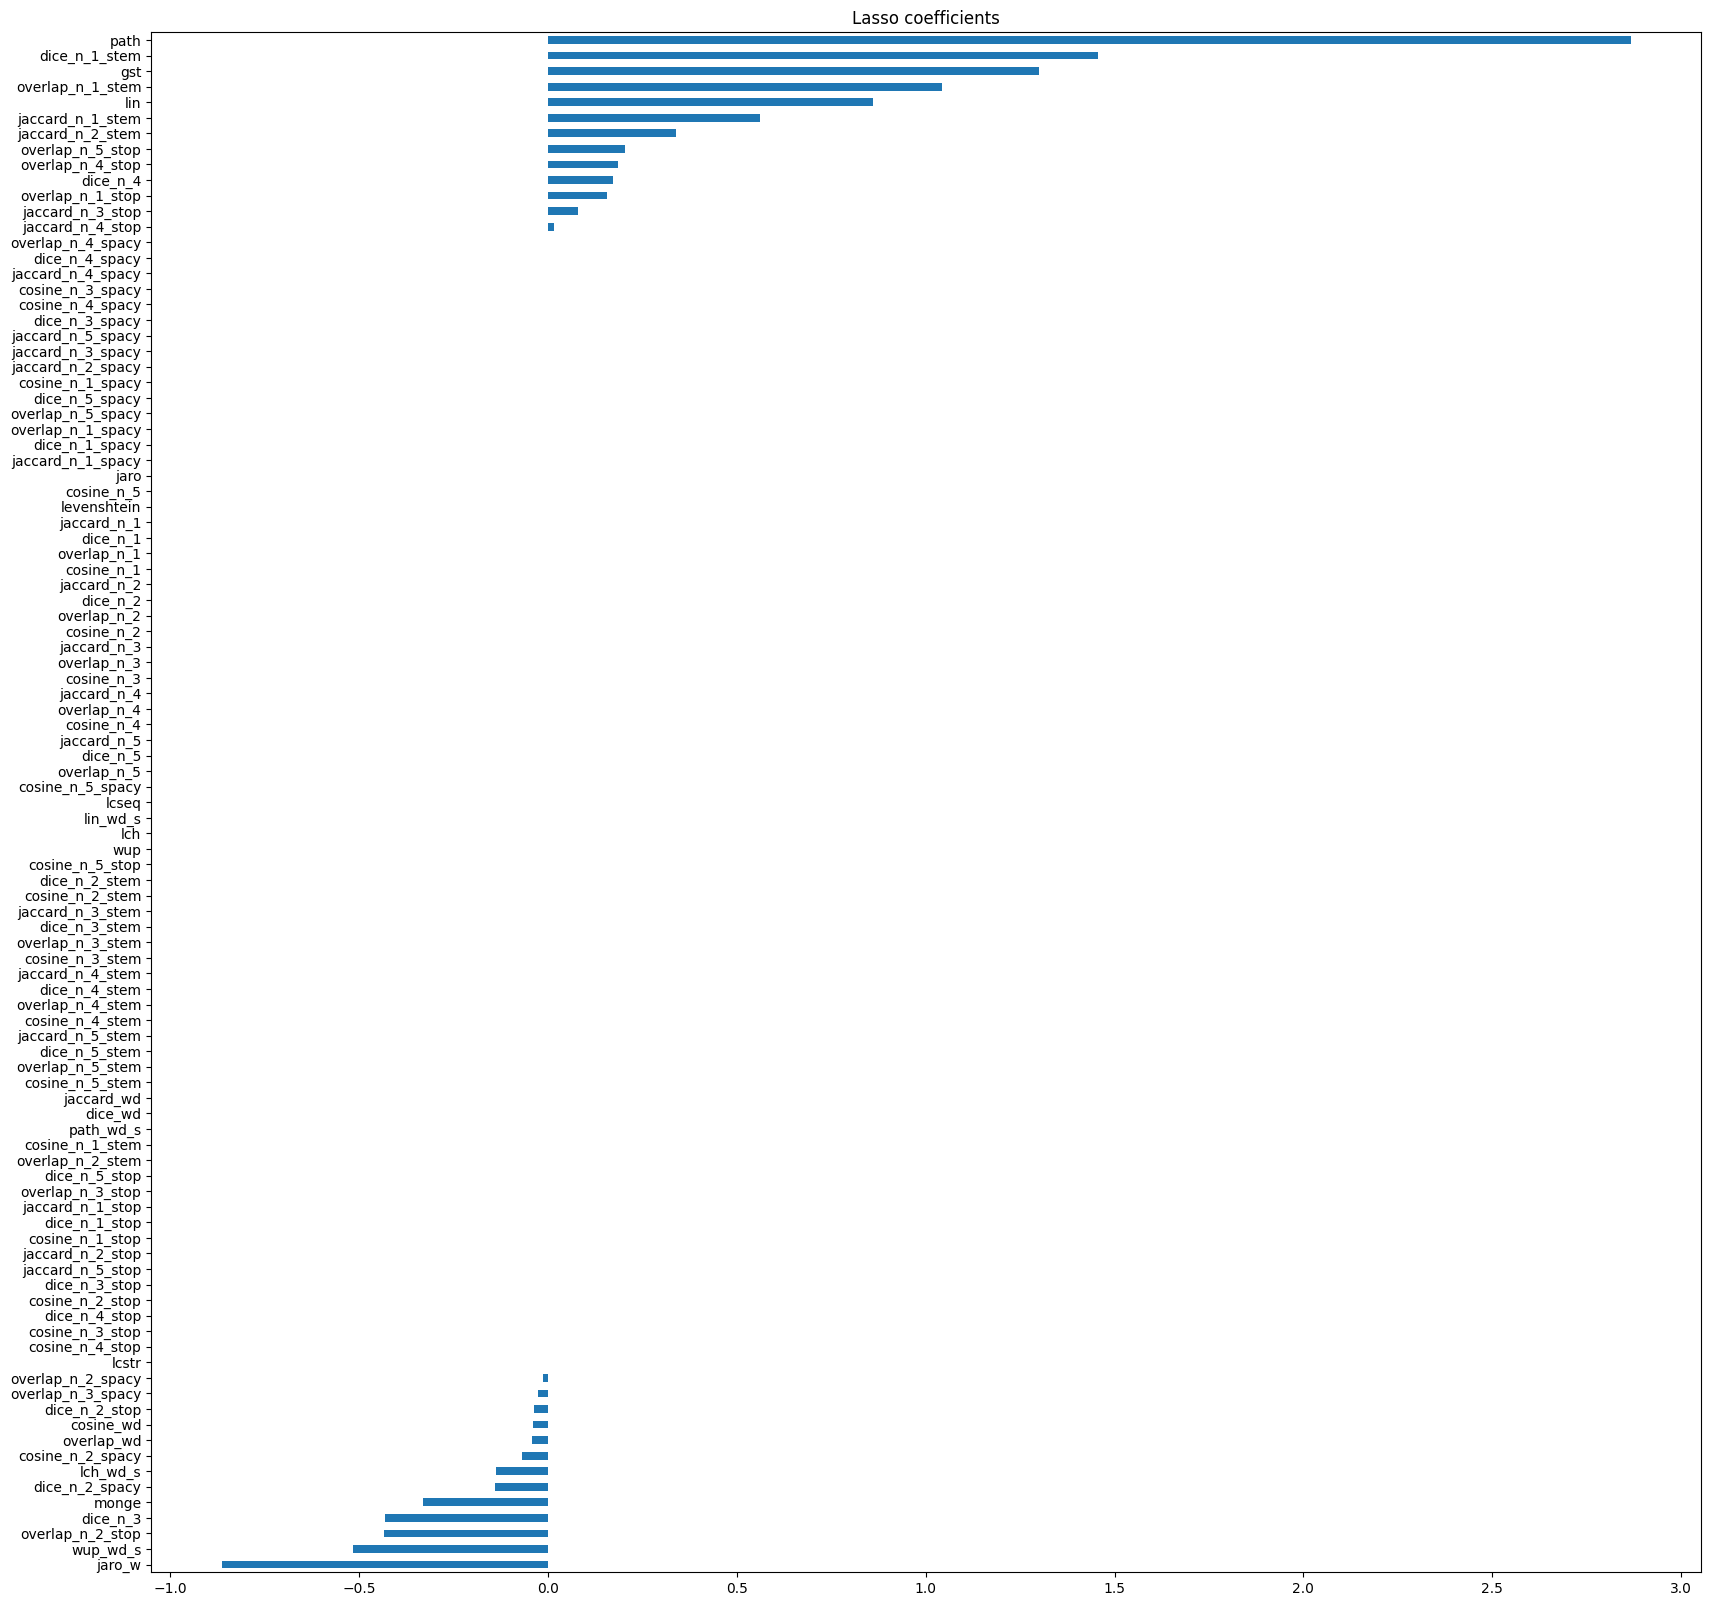

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 1/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 3/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 2/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 4/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 5/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 6/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 7/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 8/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[

In [30]:
model = Lasso(max_iter=100000, tol=0.01, random_state=0)
grid = {'model__alpha': np.linspace(0.00001, 0.01, 100),}


lasso_gscv_vid = train_and_test(model, grid, X_train_vid, y_train_vid, scaler=MinMaxScaler())

plot_lasso_coef(lasso_gscv_vid, X_train_vid, (20, 20))

pos_coef_vid = lasso_gscv_vid.best_estimator_.named_steps['model'].coef_ != 0
pos_coef_vid = X_train_vid.columns[pos_coef_vid]

X_train_pos_vid = X_train_vid[pos_coef_vid]
X_test_pos_vid = X_test_vid[pos_coef_vid]

# Fix the random state
rf = RandomForestRegressor(random_state=42)
forest_param_grid = {'model__n_estimators': np.arange(100, 500, 50), 
                     'model__min_samples_leaf': [2, 4, 6, 8, 10],
                        'model__max_features': ['sqrt', 'log2'],
                        # 'model__max_depth' : [None, 4, 6, 8, 10],
                    'model__n_jobs': [-1]}
rf_gscv_pos_vid = train_and_test(rf, forest_param_grid, X_train_pos_vid, y_train_vid)

In [31]:
pd.DataFrame(rf_gscv_pos_vid.cv_results_).sort_values(by='rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
7       1.076765      0.029084         0.092031        0.014625   
6       1.003396      0.069456         0.097492        0.015656   
5       0.902457      0.039824         0.077235        0.011782   
4       0.744051      0.044413         0.088804        0.026121   
1       0.368831      0.041269         0.049852        0.005825   

  param_model__max_features param_model__min_samples_leaf  \
7                      sqrt                             2   
6                      sqrt                             2   
5                      sqrt                             2   
4                      sqrt                             2   
1                      sqrt                             2   

  param_model__n_estimators param_model__n_jobs  \
7                       450                  -1   
6                       400                  -1   
5                       350                  -1   
4                       300                  -1   
1                       150                  -1   

                                              params  split0_test_score  \
7  {'model__max_features': 'sqrt', 'model__min_sa...           0.778976   
6  {'model__max_features': 'sqrt', 'model__min_sa...           0.778973   
5  {'model__max_features': 'sqrt', 'model__min_sa...           0.778781   
4  {'model__max_features': 'sqrt', 'model__min_sa...           0.778675   
1  {'model__max_features': 'sqrt', 'model__min_sa...           0.777750   

   split1_test_score  split2_test_score  split3_test_score  split4_test_score  \
7           0.826756           0.854410           0.811908           0.808809   
6           0.825609           0.854236           0.812451           0.808801   
5           0.824984           0.856252           0.813532           0.808346   
4           0.823516           0.857411           0.813277           0.807242   
1           0.821855           0.854640           0.813636           0.808503   

   split5_test_score  split6_test_score  split7_test_score  split8_test_score  \
7           0.866824           0.813790           0.838205           0.874416   
6           0.866647           0.814027           0.837460           0.875401   
5           0.867822           0.813672           0.837166           0.874378   
4           0.867274           0.811501           0.836896           0.874964   
1           0.864645           0.813574           0.836590           0.879331   

   split9_test_score  mean_test_score  std_test_score  rank_test_score  
7           0.816889         0.829098        0.027944                1  
6           0.815794         0.828940        0.028060                2  
5           0.814330         0.828926        0.028337                3  
4           0.814142         0.828490        0.028731                4  
1           0.812209         0.828273        0.028926                5

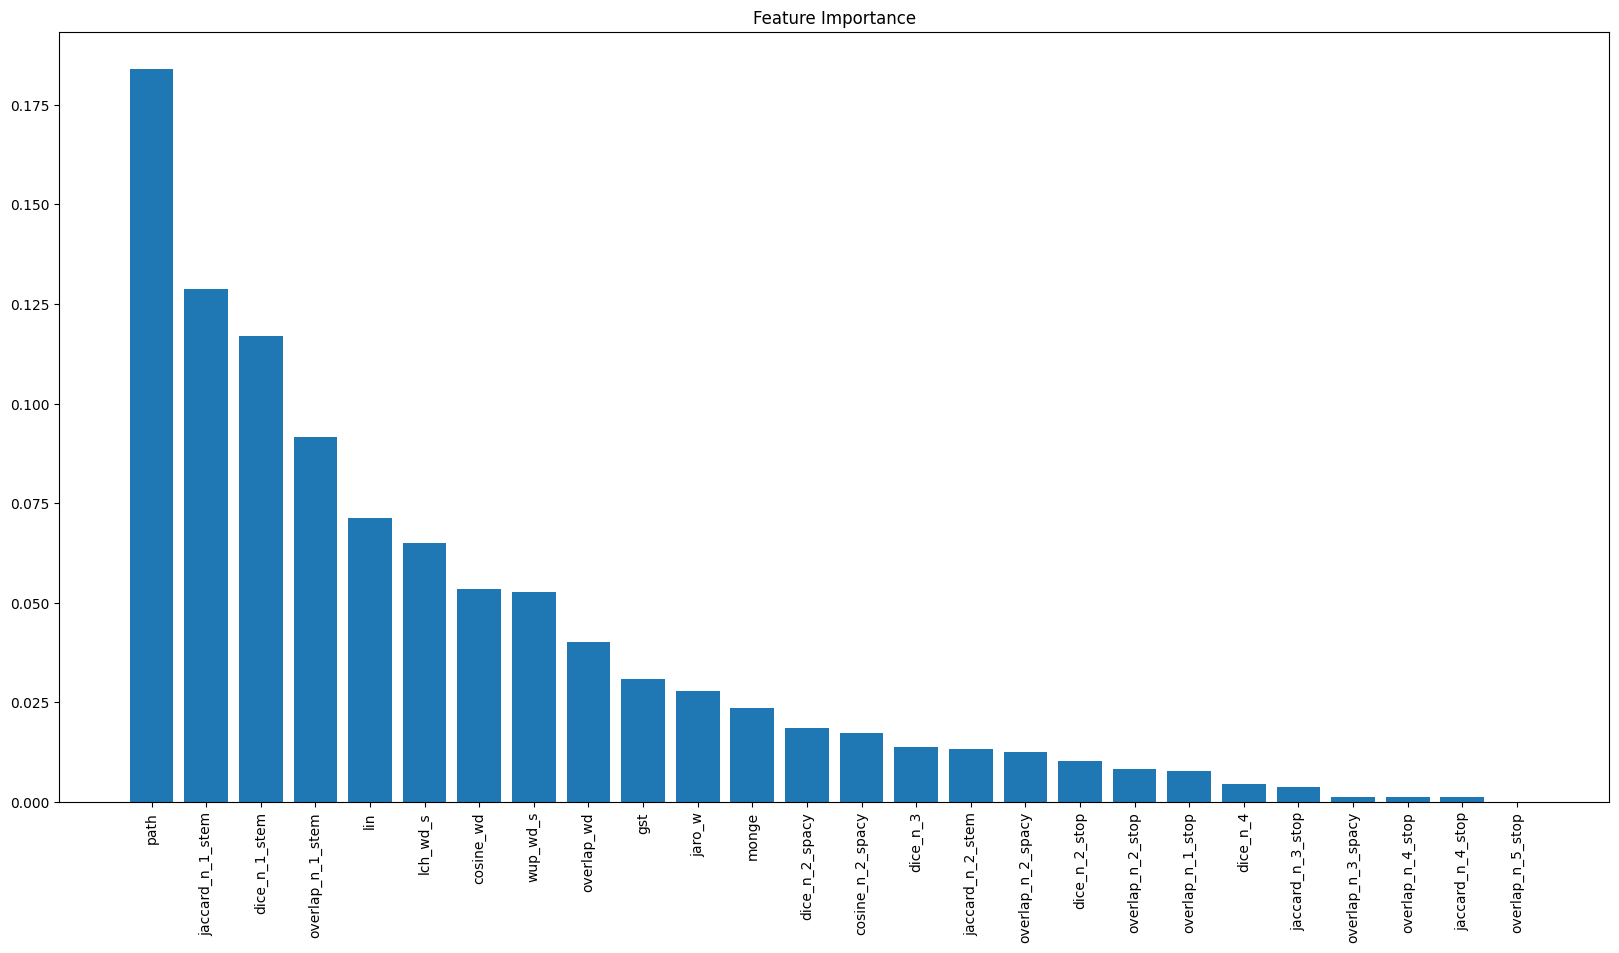

MSRvid: Pearson correlation between predicted and true values: 0.8560


In [32]:
plot_feature_importances(rf_gscv_pos_vid.best_estimator_['model'], X_train_pos_vid)

y_pred_pos_vid = rf_gscv_pos_vid.predict(X_test_pos_vid)
print("MSRvid: Pearson correlation between predicted and true values: {:.4f}".format(pearsonr(y_pred_pos_vid, y_test_vid)[0]))

### SMTeuroparl

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10; 1/100] START model__alpha=1e-05.......................................
[CV 2/10; 1/100] START model__alpha=1e-05.......................................
[CV 3/10; 1/100] START model__alpha=1e-05.......................................
[CV 4/10; 1/100] START model__alpha=1e-05.......................................
[CV 5/10; 1/100] START model__alpha=1e-05.......................................
[CV 6/10; 1/100] START model__alpha=1e-05.......................................
[CV 7/10; 1/100] START model__alpha=1e-05.......................................
[CV 8/10; 1/100] START model__alpha=1e-05.......................................
[CV 9/10; 1/100] START model__alpha=1e-05.......................................
[CV 10/10; 1/100] START model__alpha=1e-05......................................
[CV 1/10; 2/100] START model__alpha=0.00011090909090909092......................
[CV 2/10; 2/100] START model__alpha=0.000110

/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.010e+00, tolerance: 3.319e+00
  model = cd_fast.enet_coordinate_descent(
/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.392e+01, tolerance: 3.064e+00
  model = cd_fast.enet_coordinate_descent(
/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not conv

[CV 2/10; 1/100] END ........model__alpha=1e-05;, score=0.625 total time=   3.5s
[CV 3/10; 1/100] END ........model__alpha=1e-05;, score=0.826 total time=   3.5s
[CV 1/10; 1/100] END ........model__alpha=1e-05;, score=0.674 total time=   3.5s
[CV 4/10; 1/100] END ........model__alpha=1e-05;, score=0.854 total time=   3.5s


/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.873e+00, tolerance: 3.232e+00
  model = cd_fast.enet_coordinate_descent(
/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.001e+01, tolerance: 3.551e+00
  model = cd_fast.enet_coordinate_descent(
/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not conv

[CV 10/10; 1/100] END .......model__alpha=1e-05;, score=0.633 total time=   3.7s
[CV 7/10; 1/100] END ........model__alpha=1e-05;, score=0.584 total time=   3.7s
[CV 5/10; 1/100] END ........model__alpha=1e-05;, score=0.745 total time=   3.7s
[CV 8/10; 1/100] END ........model__alpha=1e-05;, score=0.691 total time=   3.8s
[CV 9/10; 1/100] END ........model__alpha=1e-05;, score=0.434 total time=   3.9s


/home/alberto/Documentos/GitHub/NLP_SemanticTextualSimilarity/.venv/lib/python3.10/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.183e+01, tolerance: 3.547e+00
  model = cd_fast.enet_coordinate_descent(


[CV 6/10; 1/100] END ........model__alpha=1e-05;, score=0.263 total time=   4.4s
Best cross-validation score: 0.64
Best parameters: {'model__alpha': 0.00011090909090909092}


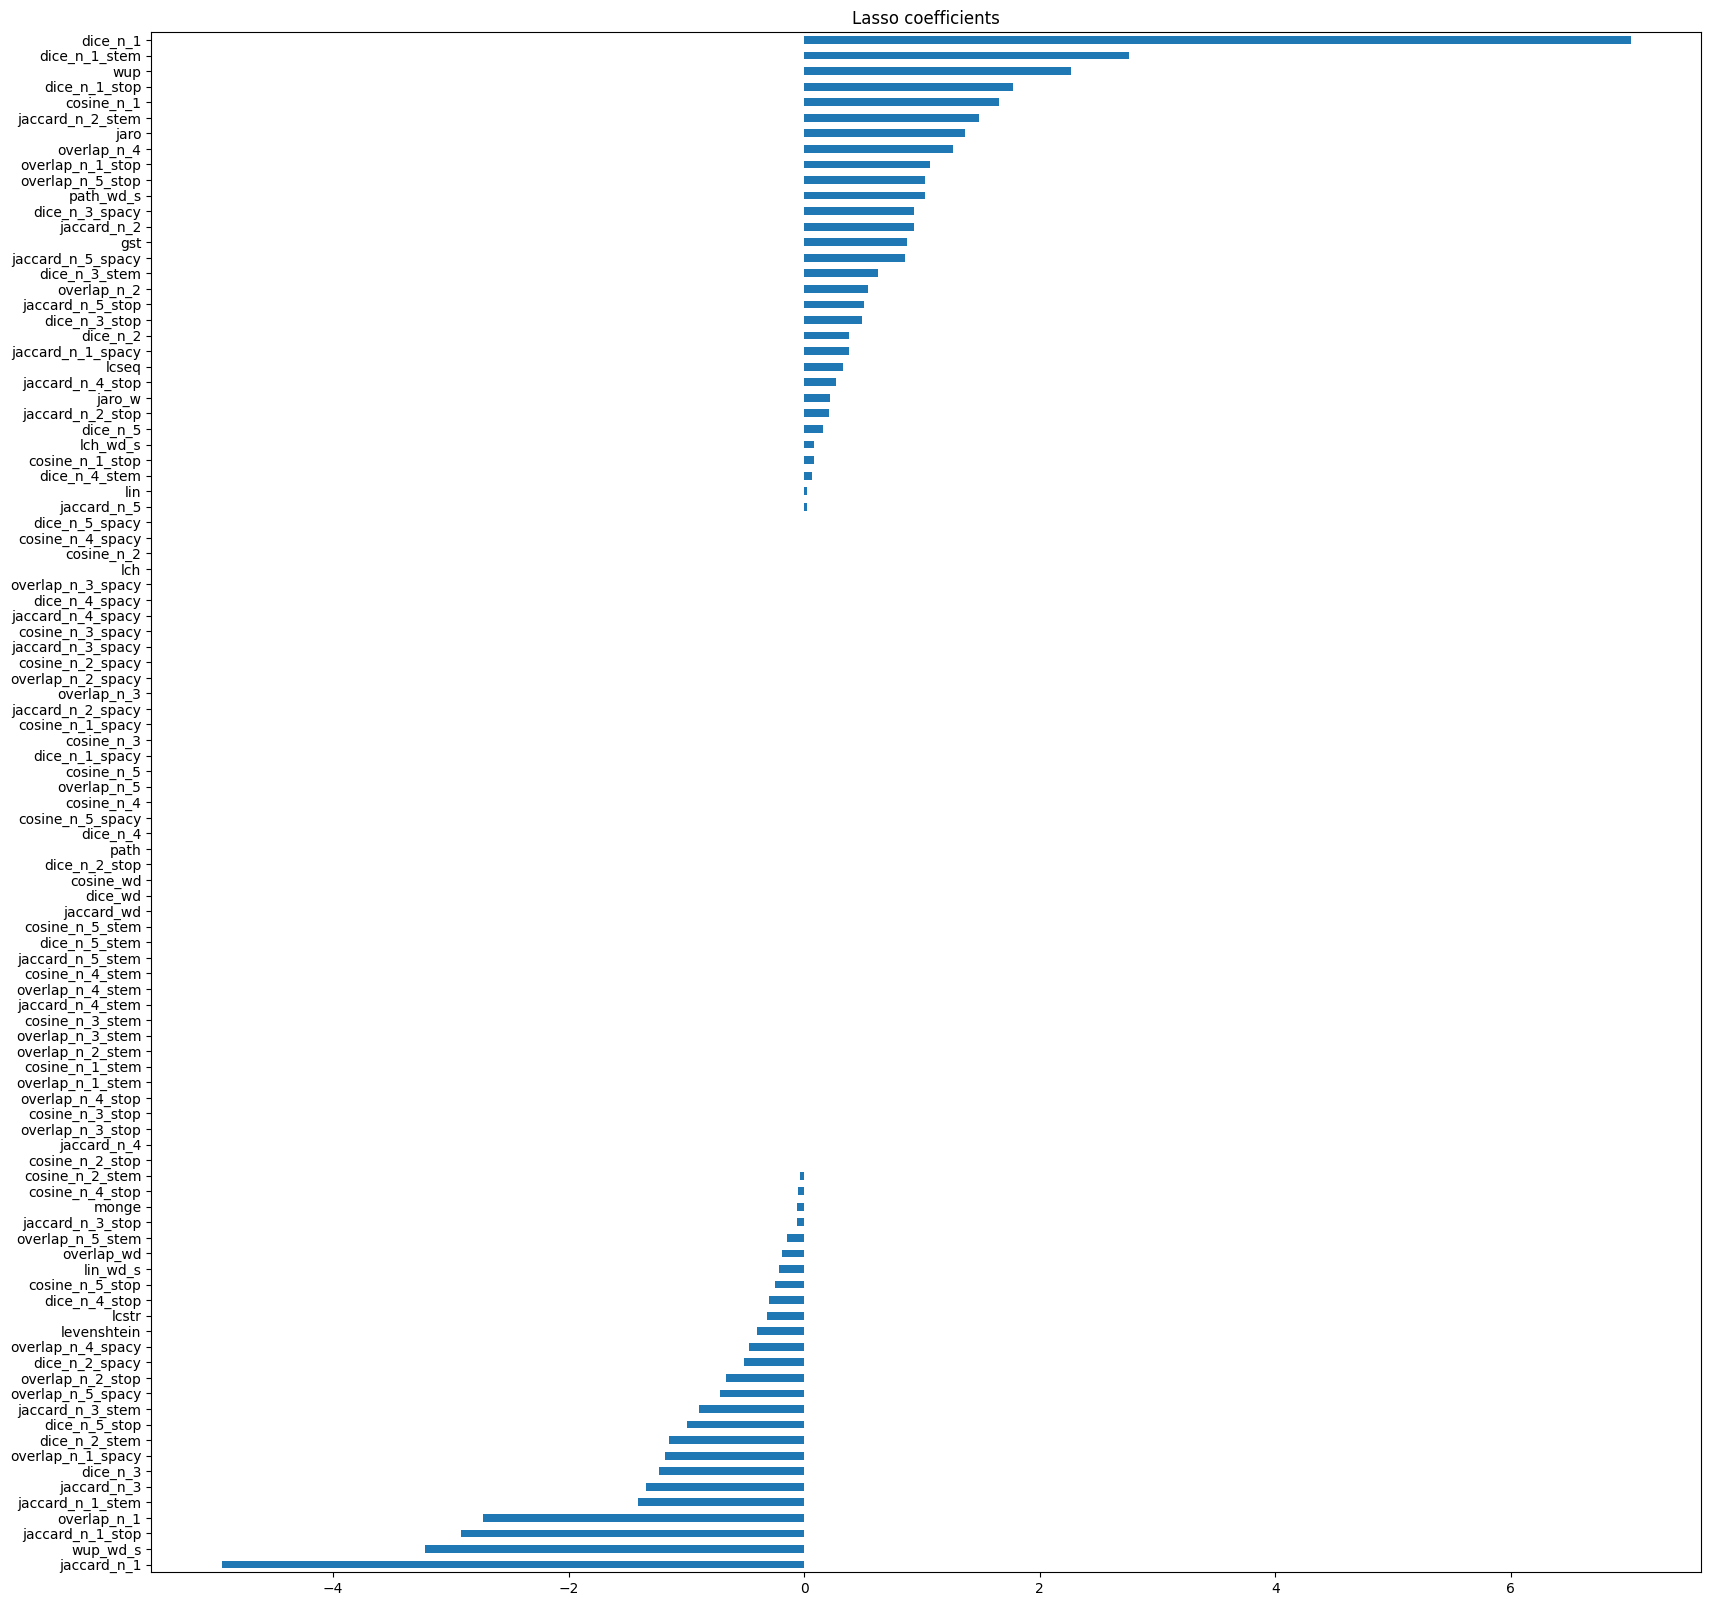

Fitting 10 folds for each of 80 candidates, totalling 800 fits
[CV 1/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 2/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 3/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 4/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 5/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 6/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 7/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[CV 8/10; 1/80] START model__max_features=sqrt, model__min_samples_leaf=2, model__n_estimators=100, model__n_jobs=-1
[

In [33]:
model = Lasso(max_iter=100000, tol=0.01, random_state=0)
grid = {'model__alpha': np.linspace(0.00001, 0.01, 100),}


lasso_gscv_eur = train_and_test(model, grid, X_train_eur, y_train_eur, scaler=MinMaxScaler())

plot_lasso_coef(lasso_gscv_eur, X_train_eur, (20, 20))

pos_coef_eur = lasso_gscv_eur.best_estimator_.named_steps['model'].coef_ != 0
pos_coef_eur = X_train_eur.columns[pos_coef_eur]

X_train_pos_eur = X_train_eur[pos_coef_eur]
X_test_pos_eur = X_test_eur[pos_coef_eur]

# Fix the random state
rf = RandomForestRegressor(random_state=42)
forest_param_grid = {'model__n_estimators': np.arange(100, 500, 50), 
                     'model__min_samples_leaf': [2, 4, 6, 8, 10],
                        'model__max_features': ['sqrt', 'log2'],
                        # 'model__max_depth' : [None, 4, 6, 8, 10],
                    'model__n_jobs': [-1]}

rf_gscv_pos_eur = train_and_test(rf, forest_param_grid, X_train_pos_eur, y_train_eur)


In [34]:
pd.DataFrame(rf_gscv_pos_eur.cv_results_).sort_values(by='rank_test_score').head()

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
41       0.482077      0.026698         0.051857        0.013434   
42       0.649257      0.037788         0.063839        0.007682   
43       0.795816      0.031908         0.084298        0.032547   
7        1.665119      0.052602         0.111514        0.024690   
45       1.151038      0.048743         0.093004        0.021384   

   param_model__max_features param_model__min_samples_leaf  \
41                      log2                             2   
42                      log2                             2   
43                      log2                             2   
7                       sqrt                             2   
45                      log2                             2   

   param_model__n_estimators param_model__n_jobs  \
41                       150                  -1   
42                       200                  -1   
43                       250                  -1   
7                        450                  -1   
45                       350                  -1   

                                               params  split0_test_score  \
41  {'model__max_features': 'log2', 'model__min_sa...           0.717615   
42  {'model__max_features': 'log2', 'model__min_sa...           0.714222   
43  {'model__max_features': 'log2', 'model__min_sa...           0.713067   
7   {'model__max_features': 'sqrt', 'model__min_sa...           0.723275   
45  {'model__max_features': 'log2', 'model__min_sa...           0.710850   

    split1_test_score  split2_test_score  split3_test_score  \
41           0.626259           0.833642           0.904570   
42           0.627613           0.832708           0.904922   
43           0.630104           0.832457           0.904547   
7            0.629030           0.838278           0.907581   
45           0.629756           0.834874           0.904870   

    split4_test_score  split5_test_score  split6_test_score  \
41           0.746132           0.420981           0.607096   
42           0.744906           0.417606           0.605651   
43           0.744971           0.406317           0.606543   
7            0.742493           0.400425           0.586160   
45           0.741595           0.405011           0.598705   

    split7_test_score  split8_test_score  split9_test_score  mean_test_score  \
41           0.761694           0.462051           0.813232         0.689327   
42           0.760823           0.470271           0.804936         0.688366   
43           0.764322           0.474140           0.800455         0.687692   
7            0.756648           0.480041           0.800583         0.686452   
45           0.759963           0.479200           0.798981         0.686381   

    std_test_score  rank_test_score  
41        0.150392                1  
42        0.148944                2  
43        0.150058                3  
7         0.152372                4  
45        0.149838                5

#### Feature Importances and Test Results

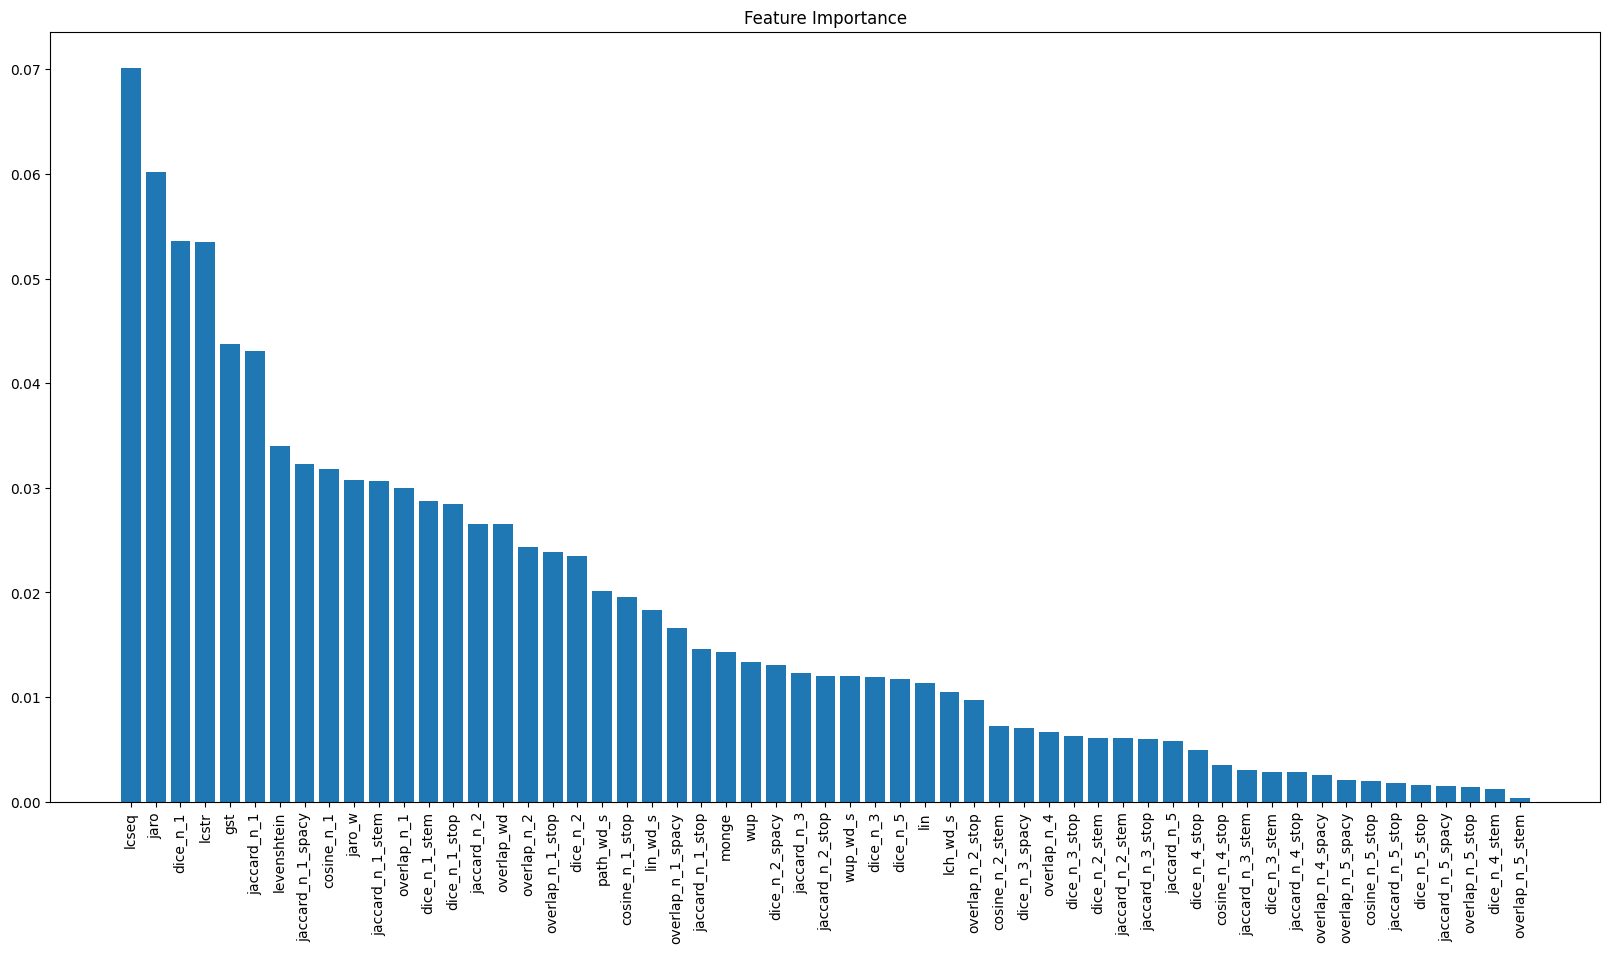

SMTeuroparl: Pearson correlation between predicted and true values: 0.3330


In [35]:
plot_feature_importances(rf_gscv_pos_eur.best_estimator_['model'], X_train_pos_eur)

y_pred_pos_eur = rf_gscv_pos_eur.predict(X_test_pos_eur)
print("SMTeuroparl: Pearson correlation between predicted and true values: {:.4f}".format(pearsonr(y_pred_pos_eur, y_test_eur)[0]))

In [36]:
y_out_total = np.concatenate([y_test_par, y_test_vid, y_test_eur, y_onwn, y_smt])
y_pred_total_pos = np.concatenate([y_pred_pos_par, y_pred_pos_vid, y_pred_pos_eur, y_pred_onwn_pos, y_pred_smt_pos])

print("Total: Pearson correlation between predicted and true values: {:.4f}".format(pearsonr(y_pred_total_pos, y_out_total)[0]))

Total: Pearson correlation between predicted and true values: 0.7770


In [63]:
ls_files = ["MSRpar", "MSRvid", "SMTeuroparl"]
ls_models = [rf_gscv_pos_par, rf_gscv_pos_vid, rf_gscv_pos_eur]
ls_cols = [X_train_pos_par.columns, X_train_pos_vid.columns, X_train_pos_eur.columns]
orig_cols = X_train_pos.columns

df_comp_train = pd.DataFrame()
for file, ind_model, cols in zip(ls_files, ls_models, ls_cols):
    print(file)
    X_train_file = df_train[df_train.file == file]
    y_train_file = X_train_file.gs
    y_total_model = rf_gscv_pos.predict(X_train_file[orig_cols])
    y_ind_model = ind_model.predict(X_train_file[cols])

    df_comp_train.loc["IND", file] = pearsonr(y_ind_model, y_train_file).statistic
    df_comp_train.loc["COL", file] = pearsonr(y_total_model, y_train_file).statistic

df_comp_train

MSRpar
MSRvid
SMTeuroparl


MSRpar    MSRvid  SMTeuroparl
IND  0.856338  0.962727     0.949431
COL  0.953298  0.961274     0.931884

In [64]:
{file:len(cols) for file, cols in zip(ls_files, ls_cols)}

{'MSRpar': 54, 'MSRvid': 26, 'SMTeuroparl': 57}

In [110]:
ls_true_pos = [y_test_par, y_test_vid, y_test_eur, y_onwn, y_smt]
ls_preds_pos = [y_pred_pos_par, y_pred_pos_vid, y_pred_pos_eur, y_pred_onwn_pos, y_pred_smt_pos]

corr_pos = pearsonr(np.concatenate(ls_true_pos), np.concatenate(ls_preds_pos))[0]
print("Total: Pearson correlation between predicted and true values: {:.4f}".format(corr_pos))

# Autoscaled correlation (ALLNORM) using Ridge
weighted_mean_pos = get_weighted_mean_corr(ls_preds_pos, ls_true_pos)

allnorm_corr_pos = get_allnorm_corr(ls_preds_pos, ls_true_pos)

df_results.loc[1, "ALL"] = corr_pos
df_results.loc[1, "ALLNORM"] = allnorm_corr_pos
df_results.loc[1, "WEIGHTED"] = weighted_mean_pos

df_results

Total: Pearson correlation between predicted and true values: 0.7770
WEIGHTED: Weighted mean correlation between predicted and true values: 0.6433
ALLNORM: Pearson correlation between predicted and true values: 0.7770
ALLNORM: beta1: 0.8880, beta2 0.7356 


ALL   ALLNORM  WEIGHTED
0  0.776656  0.776656  0.643581
1  0.776952  0.776952  0.643279